In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import pytensor.tensor as pt
import xarray as xr


In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

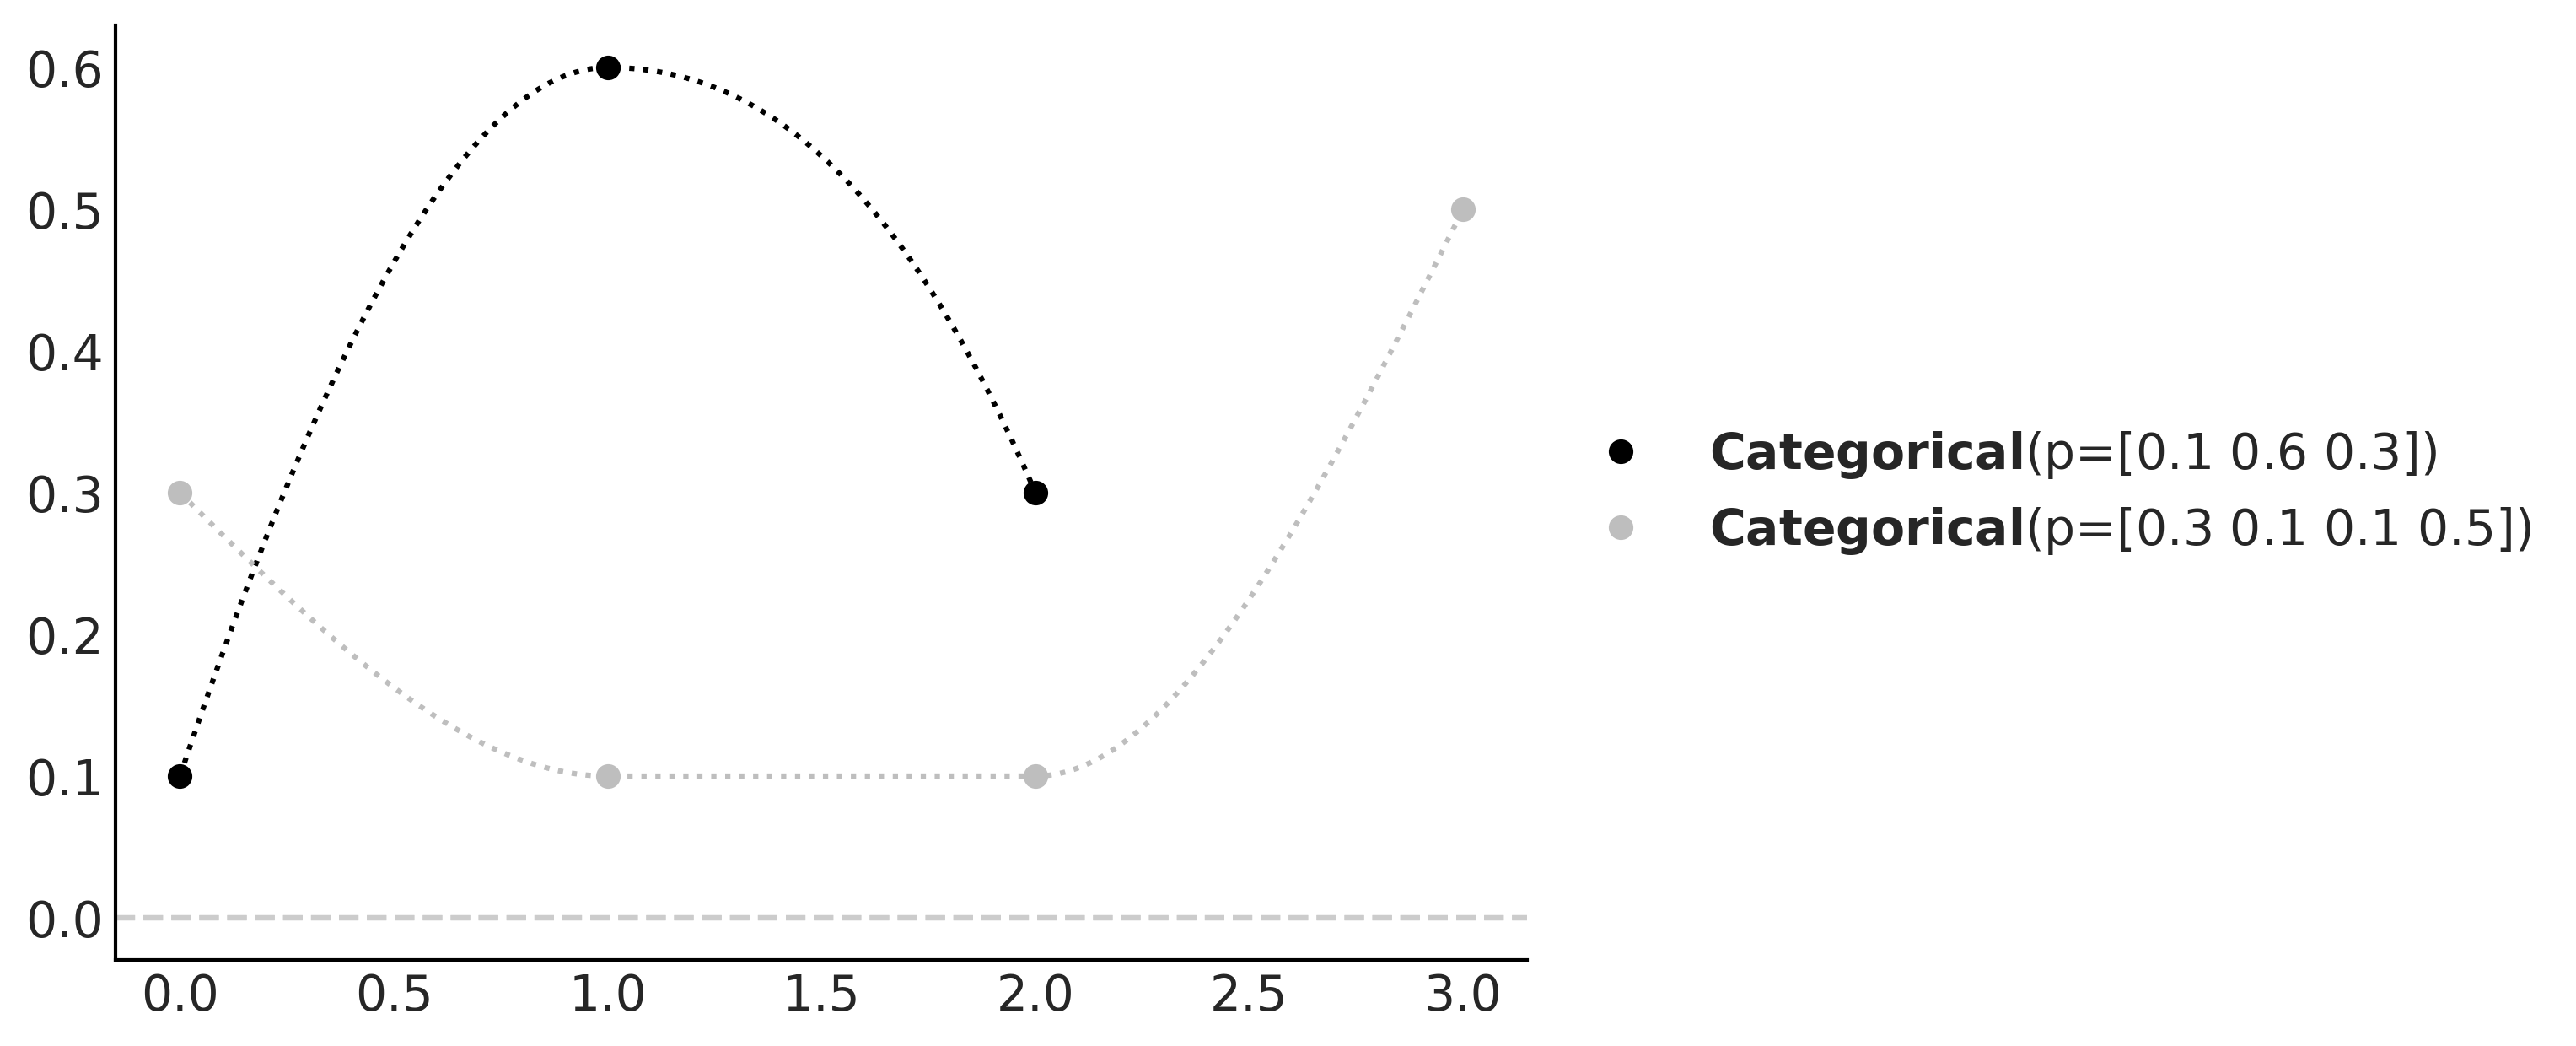

In [3]:
pz.Categorical([0.1, 0.6, 0.3]).plot_pdf(color="C0")
pz.Categorical([0.3, 0.1, 0.1, 0.5]).plot_pdf(color="C2")
plt.savefig("../fig/categorical_pmf.png")

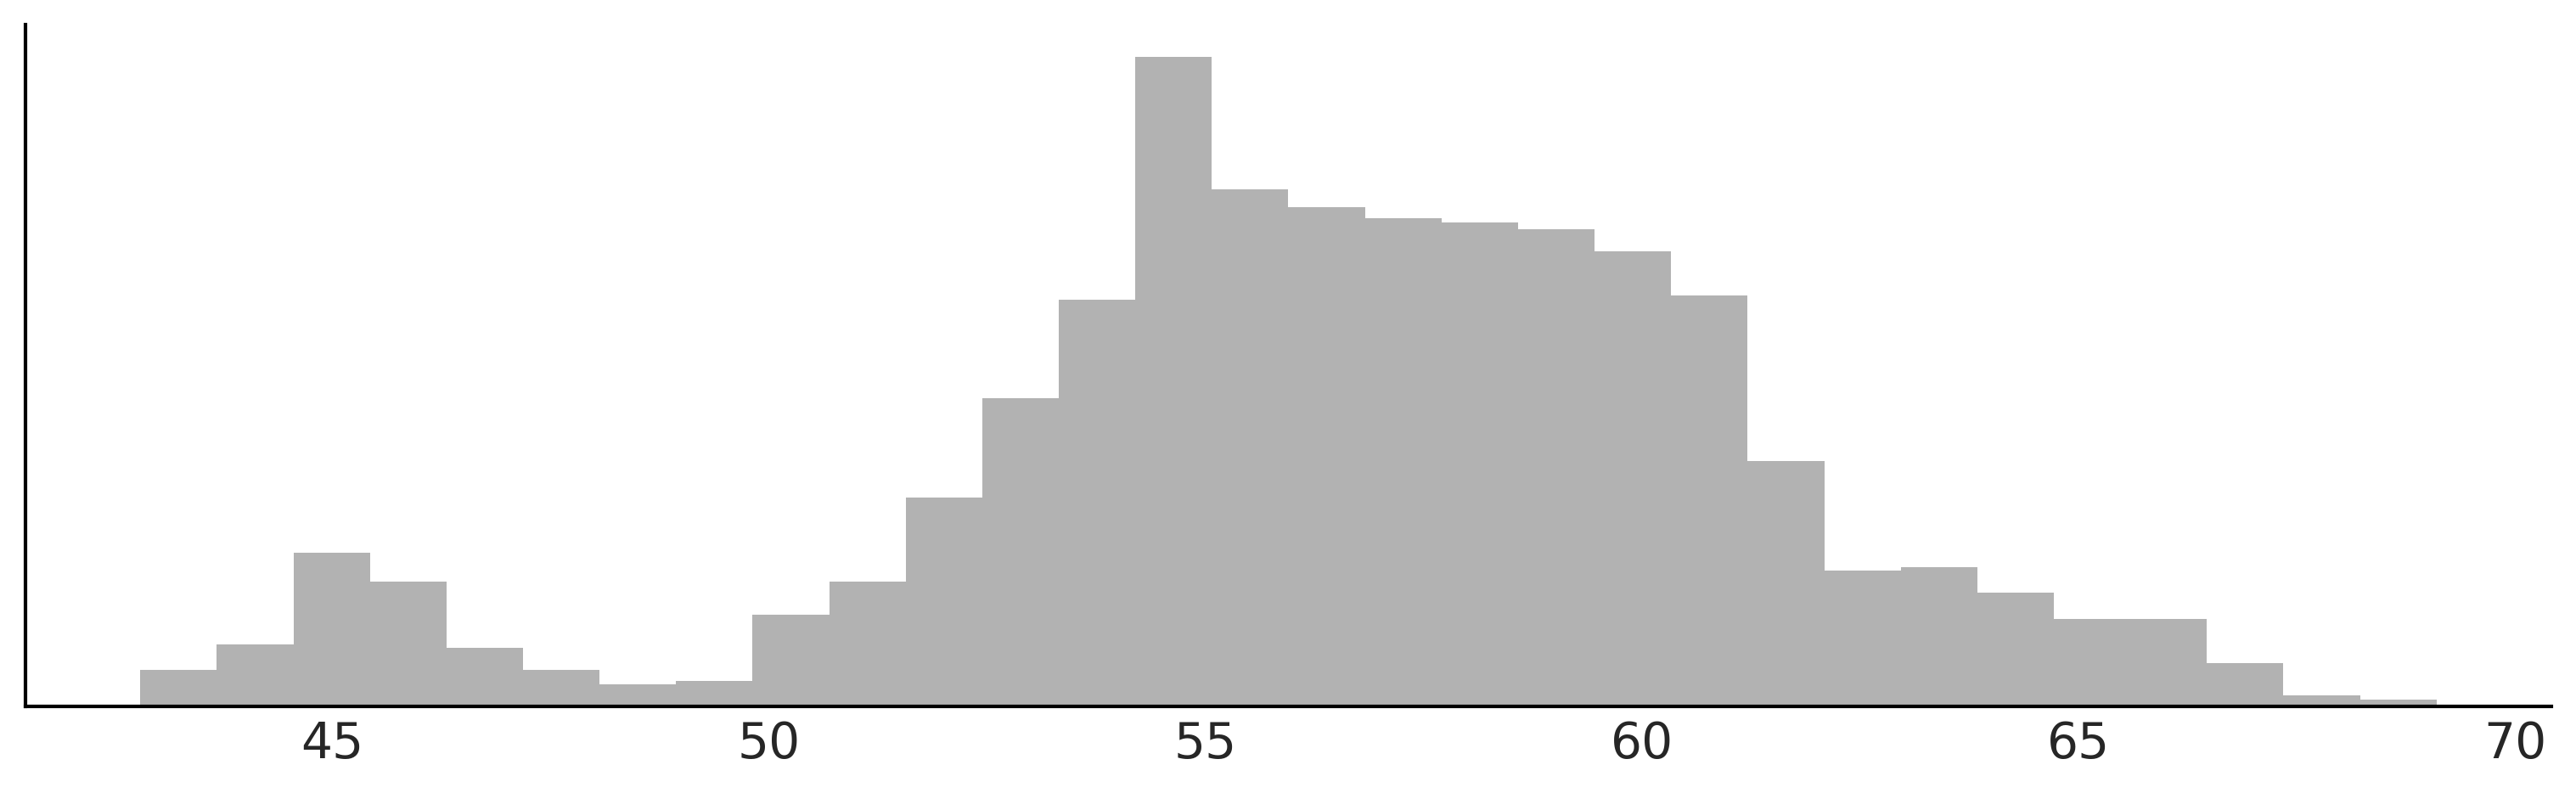

In [4]:
cs = pd.read_csv('data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
_, ax = plt.subplots(figsize=(10, 3))
ax.hist(cs_exp, density=True, bins=30, alpha=0.3)
ax.set_yticks([])
plt.savefig("../fig/cs_exp_hist.png")

In [5]:
K = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(K))
    means = pm.Normal('means', mu=cs_exp.mean(), sigma=10, shape=K)
    sd = pm.HalfNormal('sd', sigma=5)
    y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=cs_exp)
    idata_mg = pm.sample(random_seed=123)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


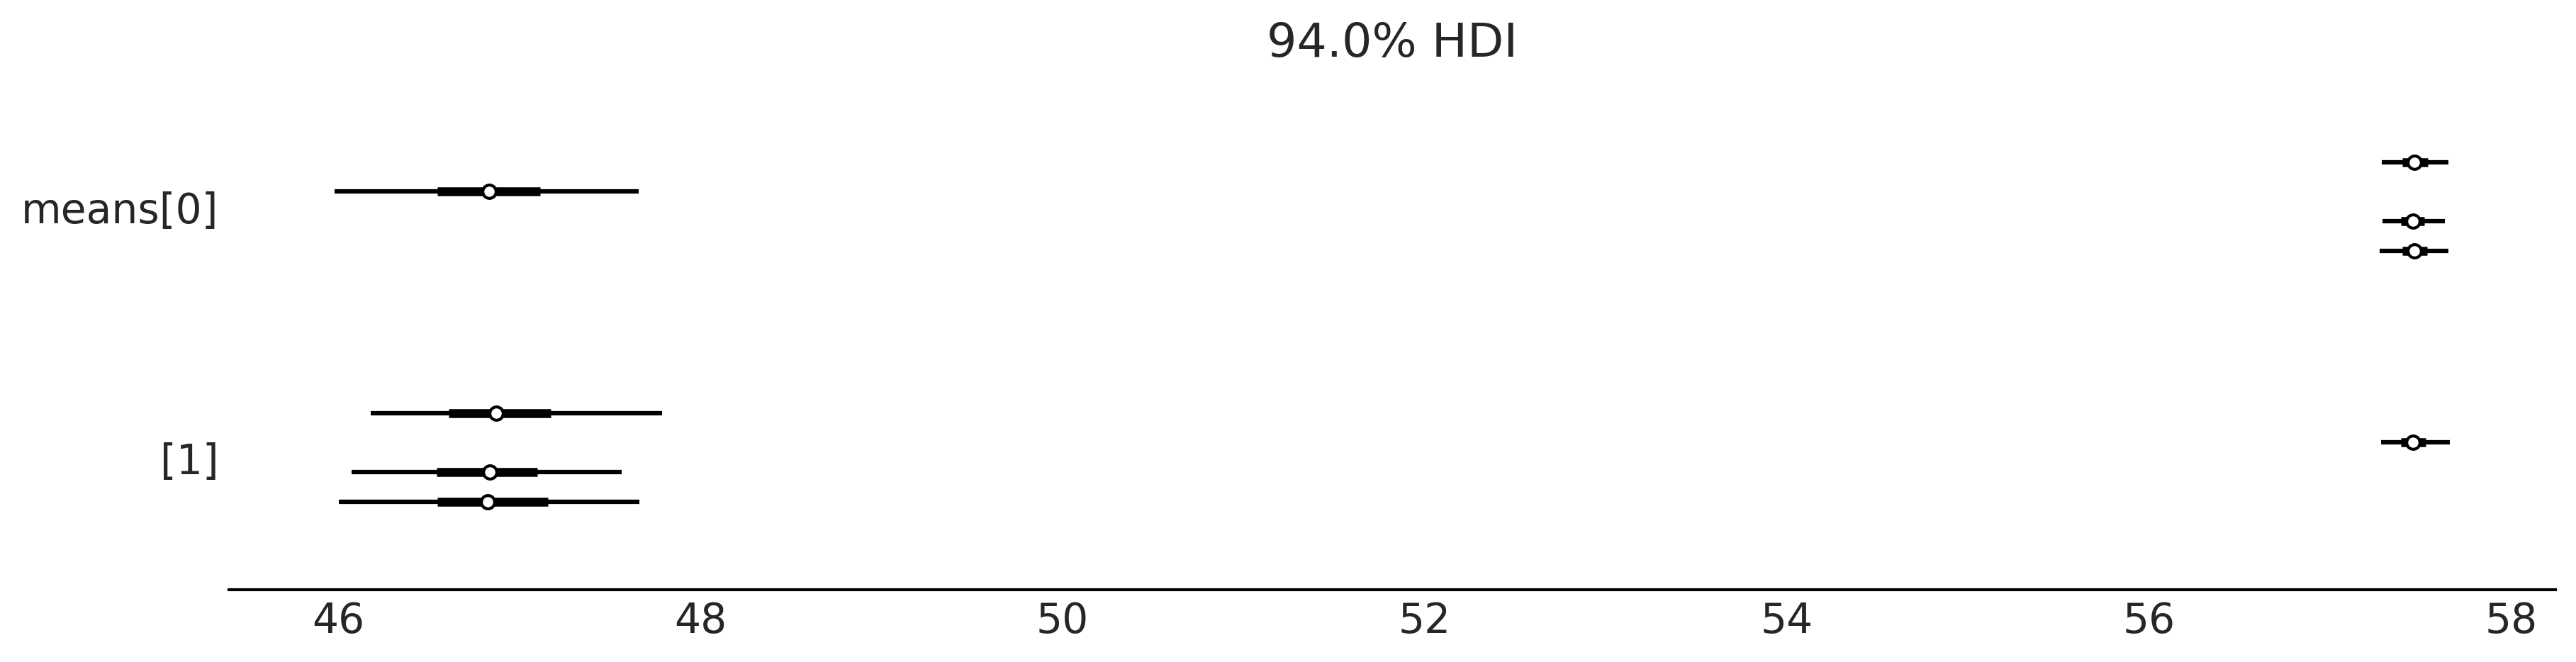

In [6]:
az.plot_forest(idata_mg, var_names="means", figsize=(12, 3))
plt.savefig("../fig/cs_means_forest_mg.png")

In [7]:
#az.summary(idata_mg, varnames)

In [8]:
K = 2
with pm.Model() as model_mgo:
    p = pm.Dirichlet('p', a=np.ones(K))
    means = pm.Normal('means', mu=cs_exp.mean(), sigma=10, shape=K,
                      transform=pm.distributions.transforms.univariate_ordered,
                      initval=np.array([cs_exp.mean()-1, cs_exp.mean()+1]))

    sd = pm.HalfNormal('sd', sigma=10)
    y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=cs_exp)
    idata_mgo = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


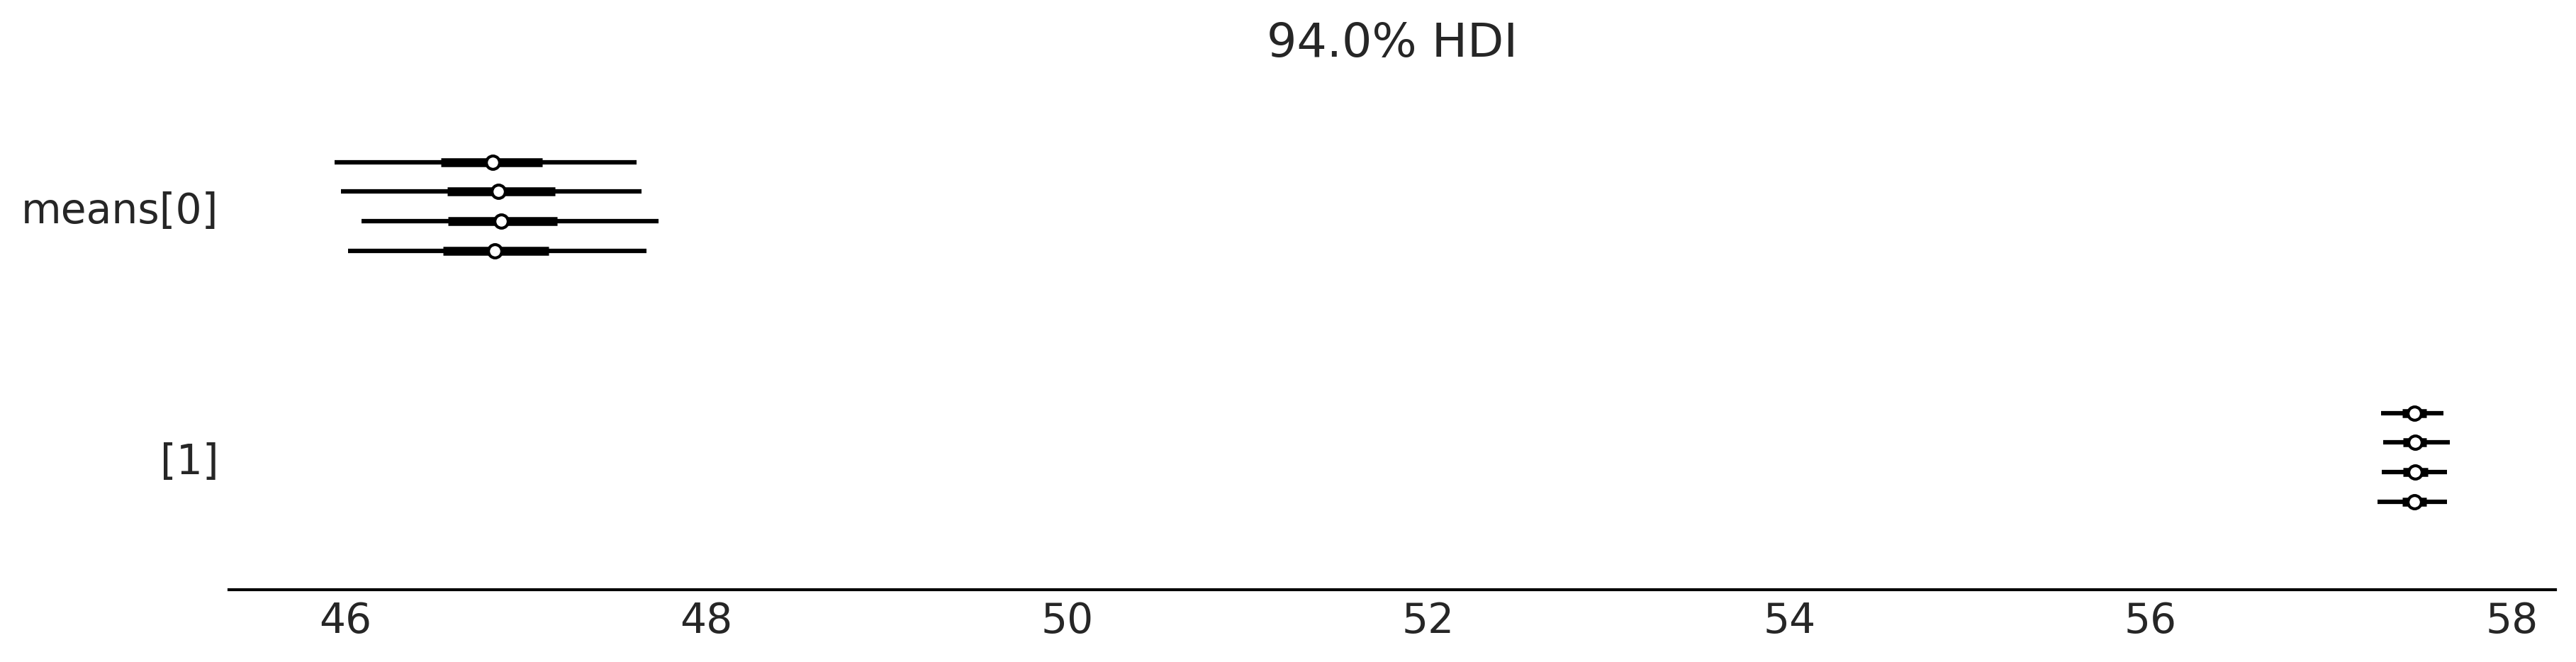

In [9]:
az.plot_forest(idata_mgo, var_names="means", figsize=(12, 3))
plt.savefig("../fig/cs_means_forest_mgo.png")

In [10]:
Ks = [2, 3, 4, 5]

models = []
idatas = []
for k in Ks:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(k))
        means = pm.Normal('means',
                          mu=np.linspace(cs_exp.min(), cs_exp.max(), k),
                          sigma=cs_exp.var() / k, shape=k,
                          transform=pm.distributions.transforms.univariate_ordered,
                          )
        sd = pm.HalfNormal('sd', sigma=5)
        y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=cs_exp)
        idata = pm.sample(random_seed=123,
                          idata_kwargs={"log_likelihood":True}
                         )
        idatas.append(idata)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


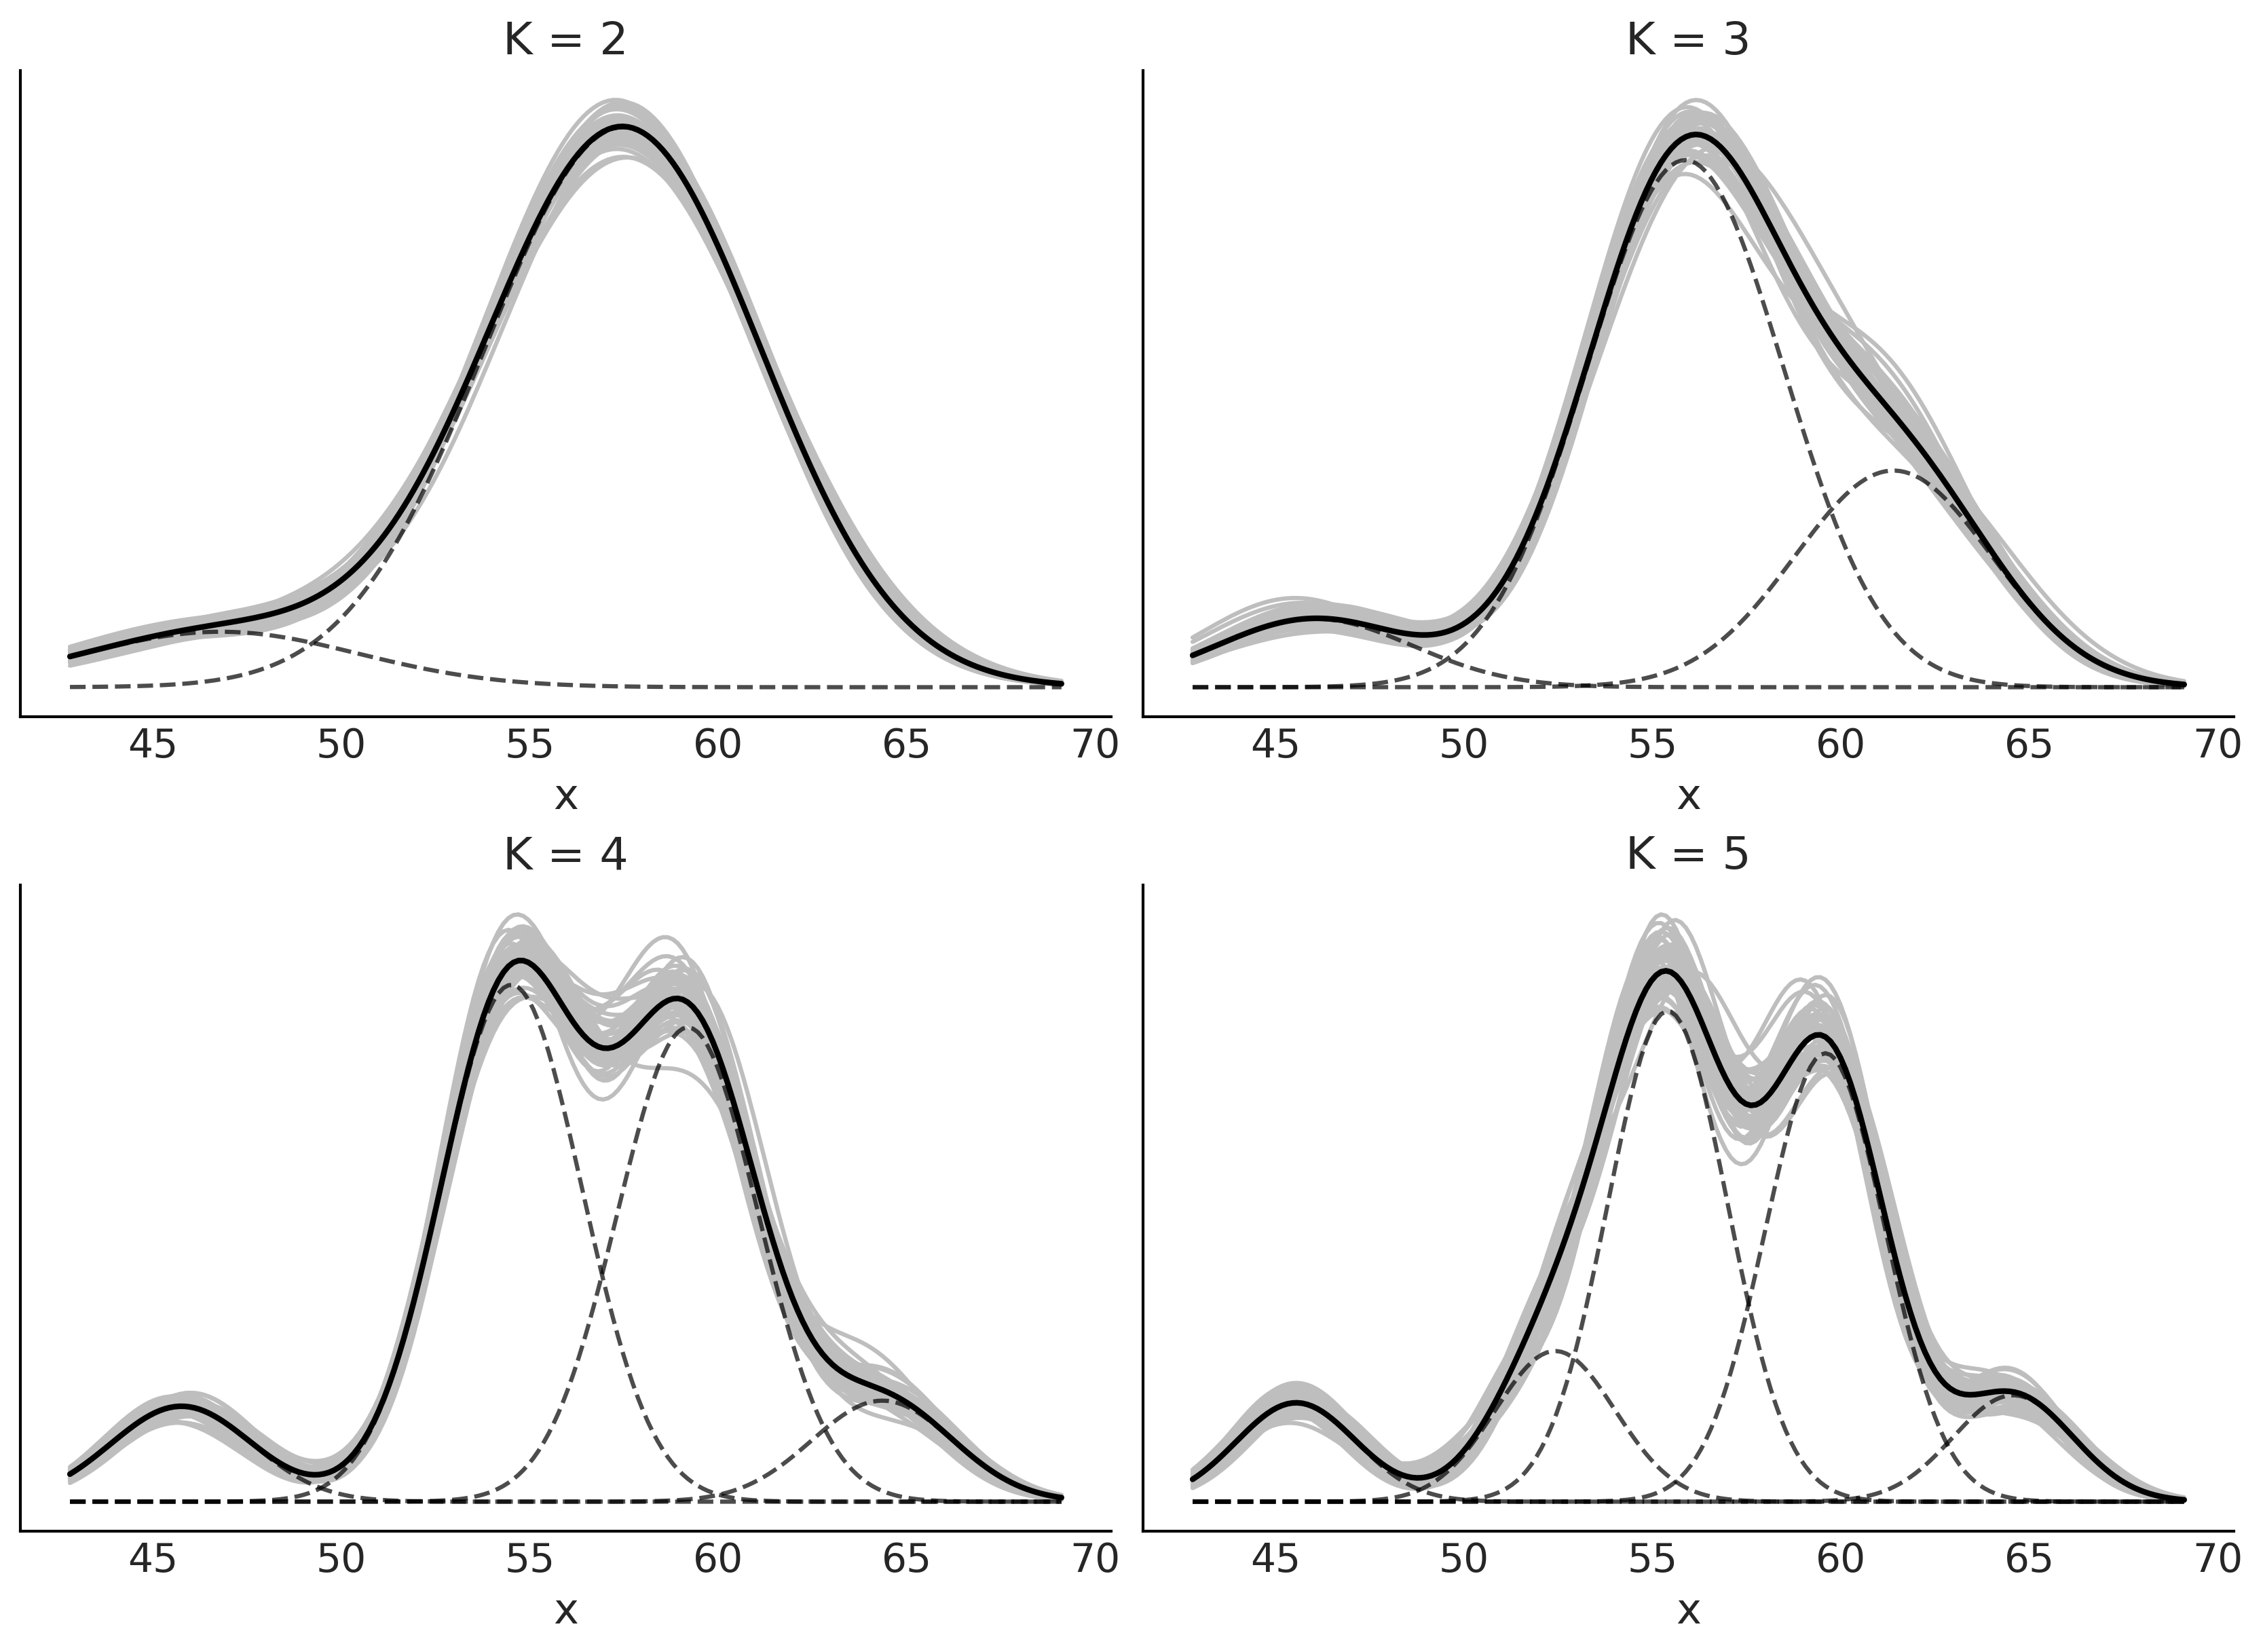

In [11]:
_, ax = plt.subplots(2, 2, figsize=(11, 8))
 
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * Ks[idx]).T

    for i_ in np.random.randint(0, posterior_x.samples.size, size=50):
        dist = pz.Normal(posterior_x['means'][:,i_], posterior_x['sd'][i_])
        ax[idx].plot(x, np.sum(dist.pdf(x_) *  posterior_x['p'][:,i_].values, 1), 'C2')
 
    p_y = posterior_x['p'].mean("samples")
    dist = pz.Normal(posterior_x['means'].mean("samples"), posterior_x['sd'].mean())
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y.values, 'k--', alpha=0.7)
         
    ax[idx].set_title('K = {}'.format(Ks[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')
plt.savefig("../fig/mixture_models_K.png")

Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


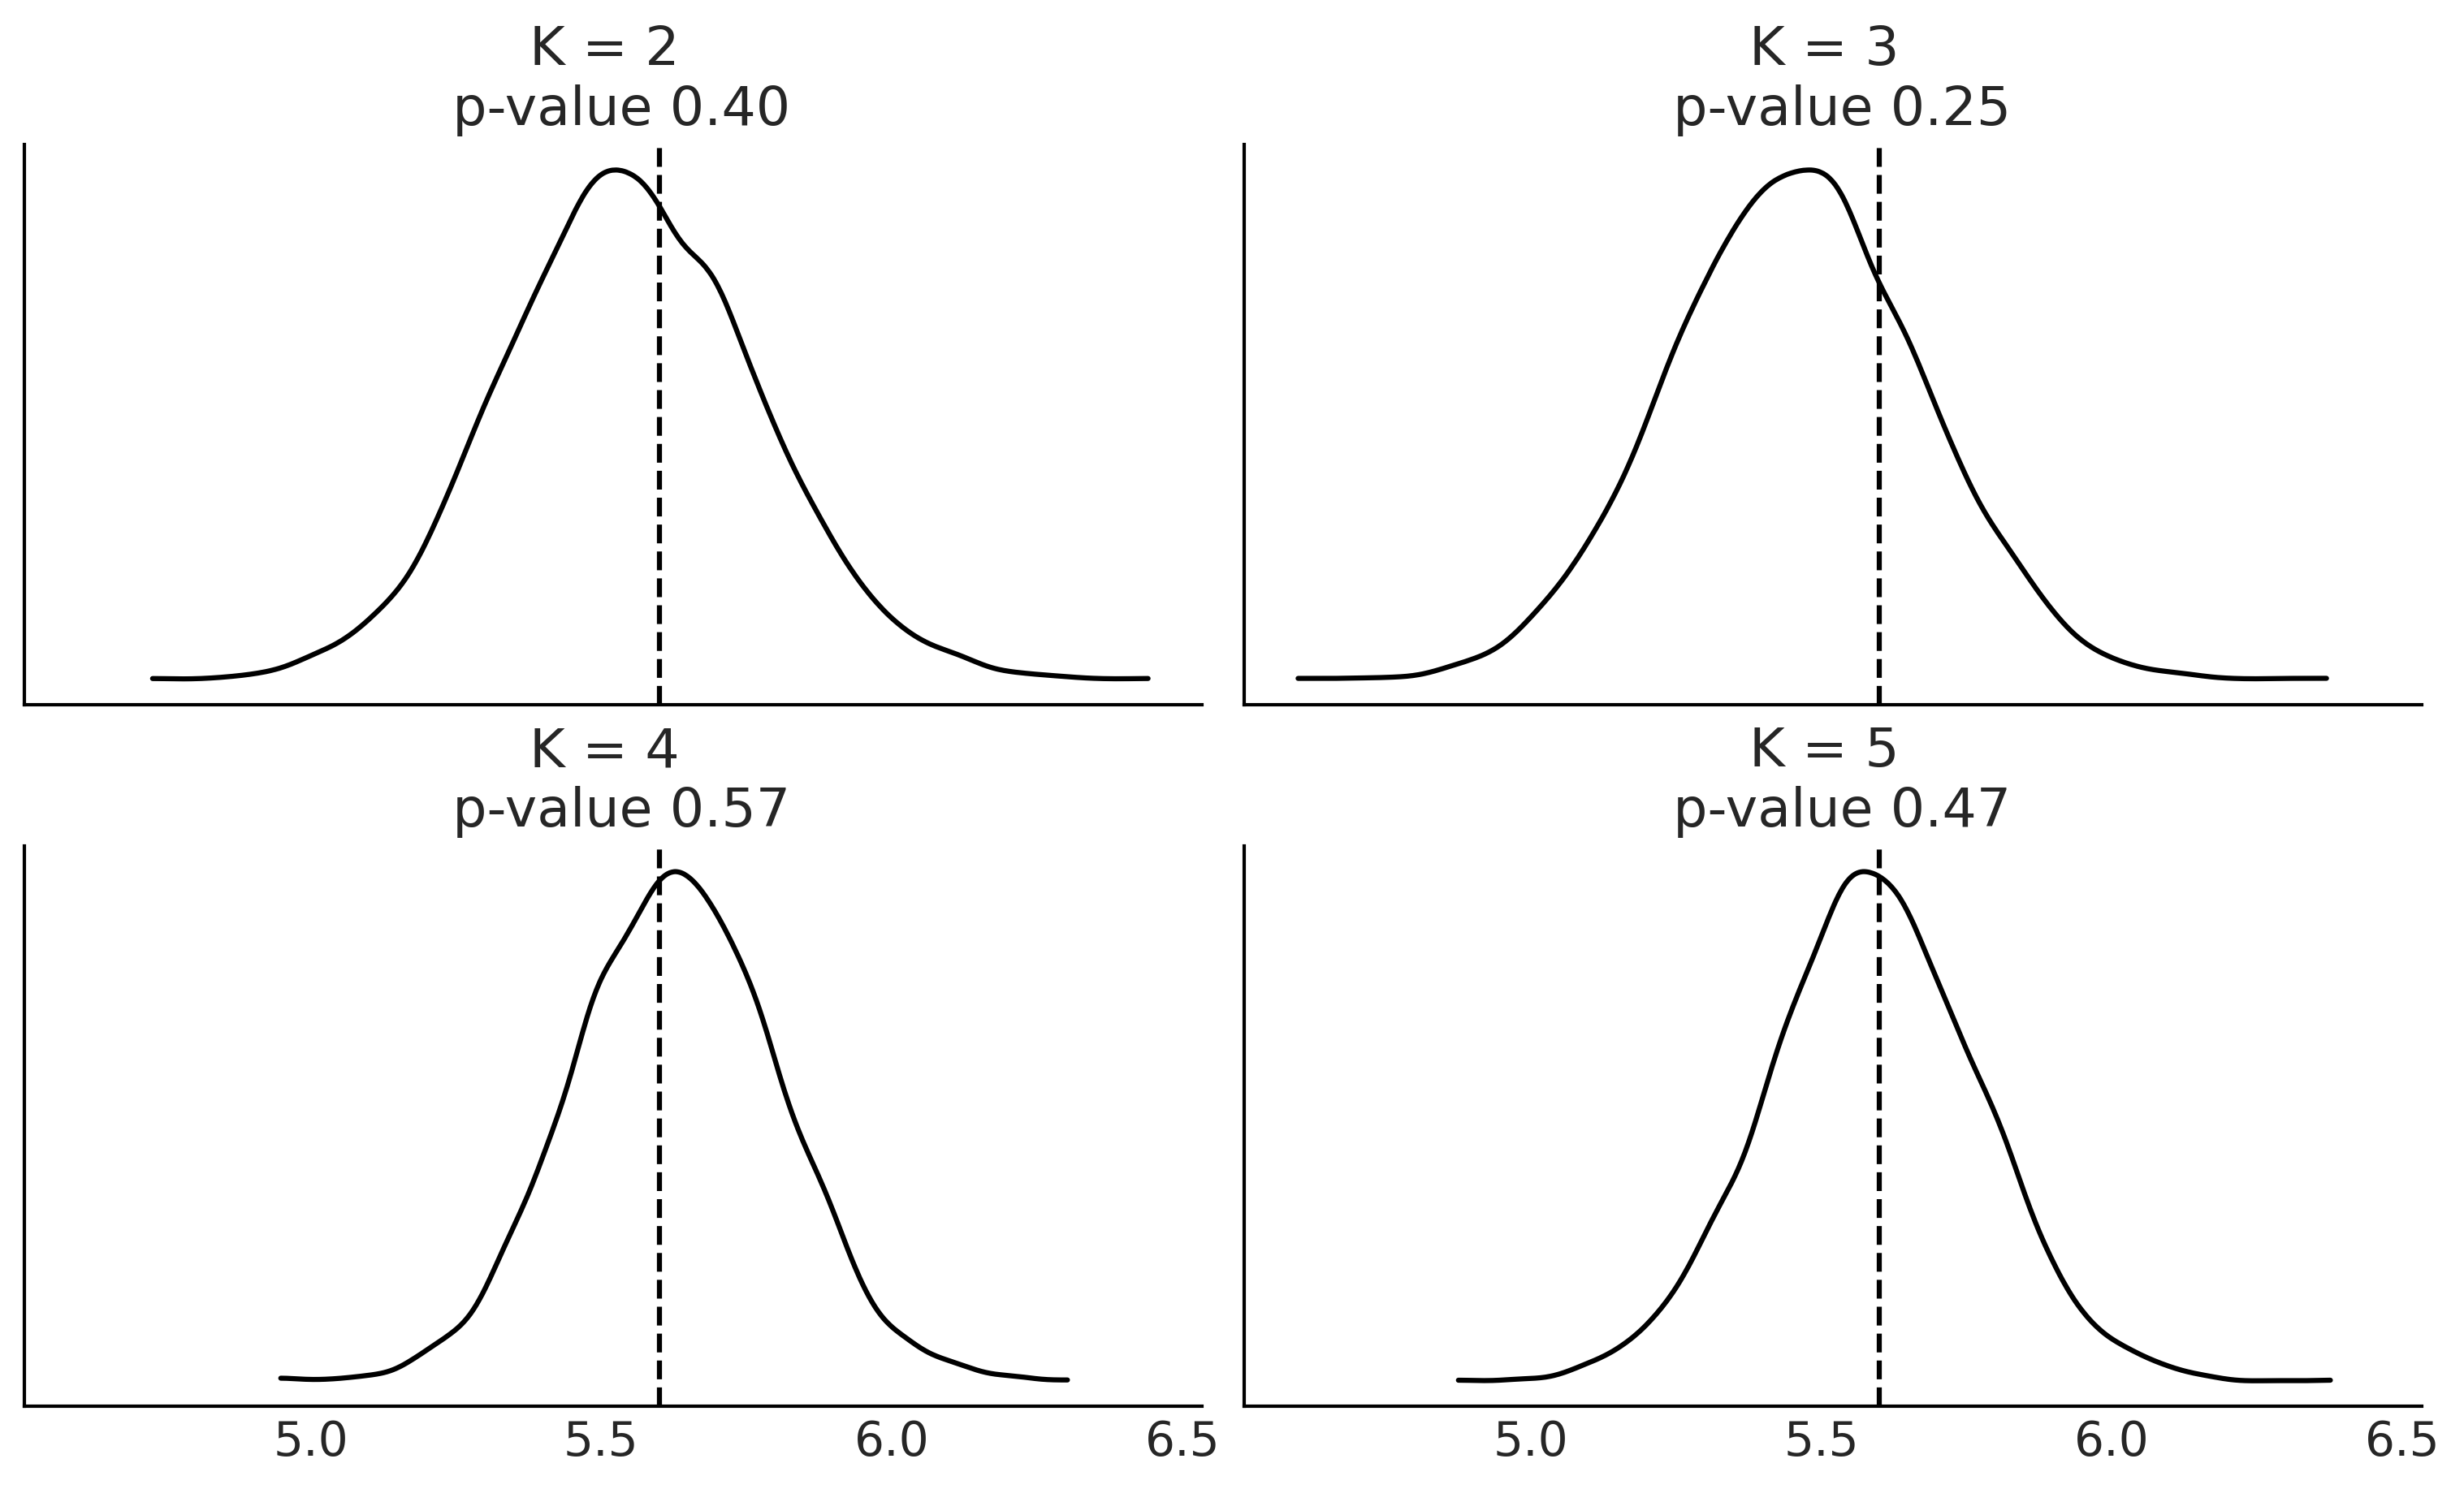

In [12]:
ppc_mm = [pm.sample_posterior_predictive(idatas[i], models[i], random_seed=4591) for i in range(4)]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))
    
T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    d_sim = d_sim.posterior_predictive["y"]
    T_sim = iqr(d_sim, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {Ks[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])


plt.savefig("../fig/mixture_models_ppc.png")

In [13]:
comp = az.compare(dict(zip([str(K) for K in Ks], idatas)))
comp

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
5,0,-5129.223680,9.953179,0.000000,1.000000e+00,30.702435,0.000000,False,log
4,1,-5139.567185,7.599073,10.343505,0.000000e+00,31.262451,4.218300,False,log
3,2,-5178.378883,5.874274,49.155203,0.000000e+00,31.866948,8.846294,False,log
2,3,-5215.993747,3.335475,86.770067,1.826095e-11,33.498902,11.956837,False,log


/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


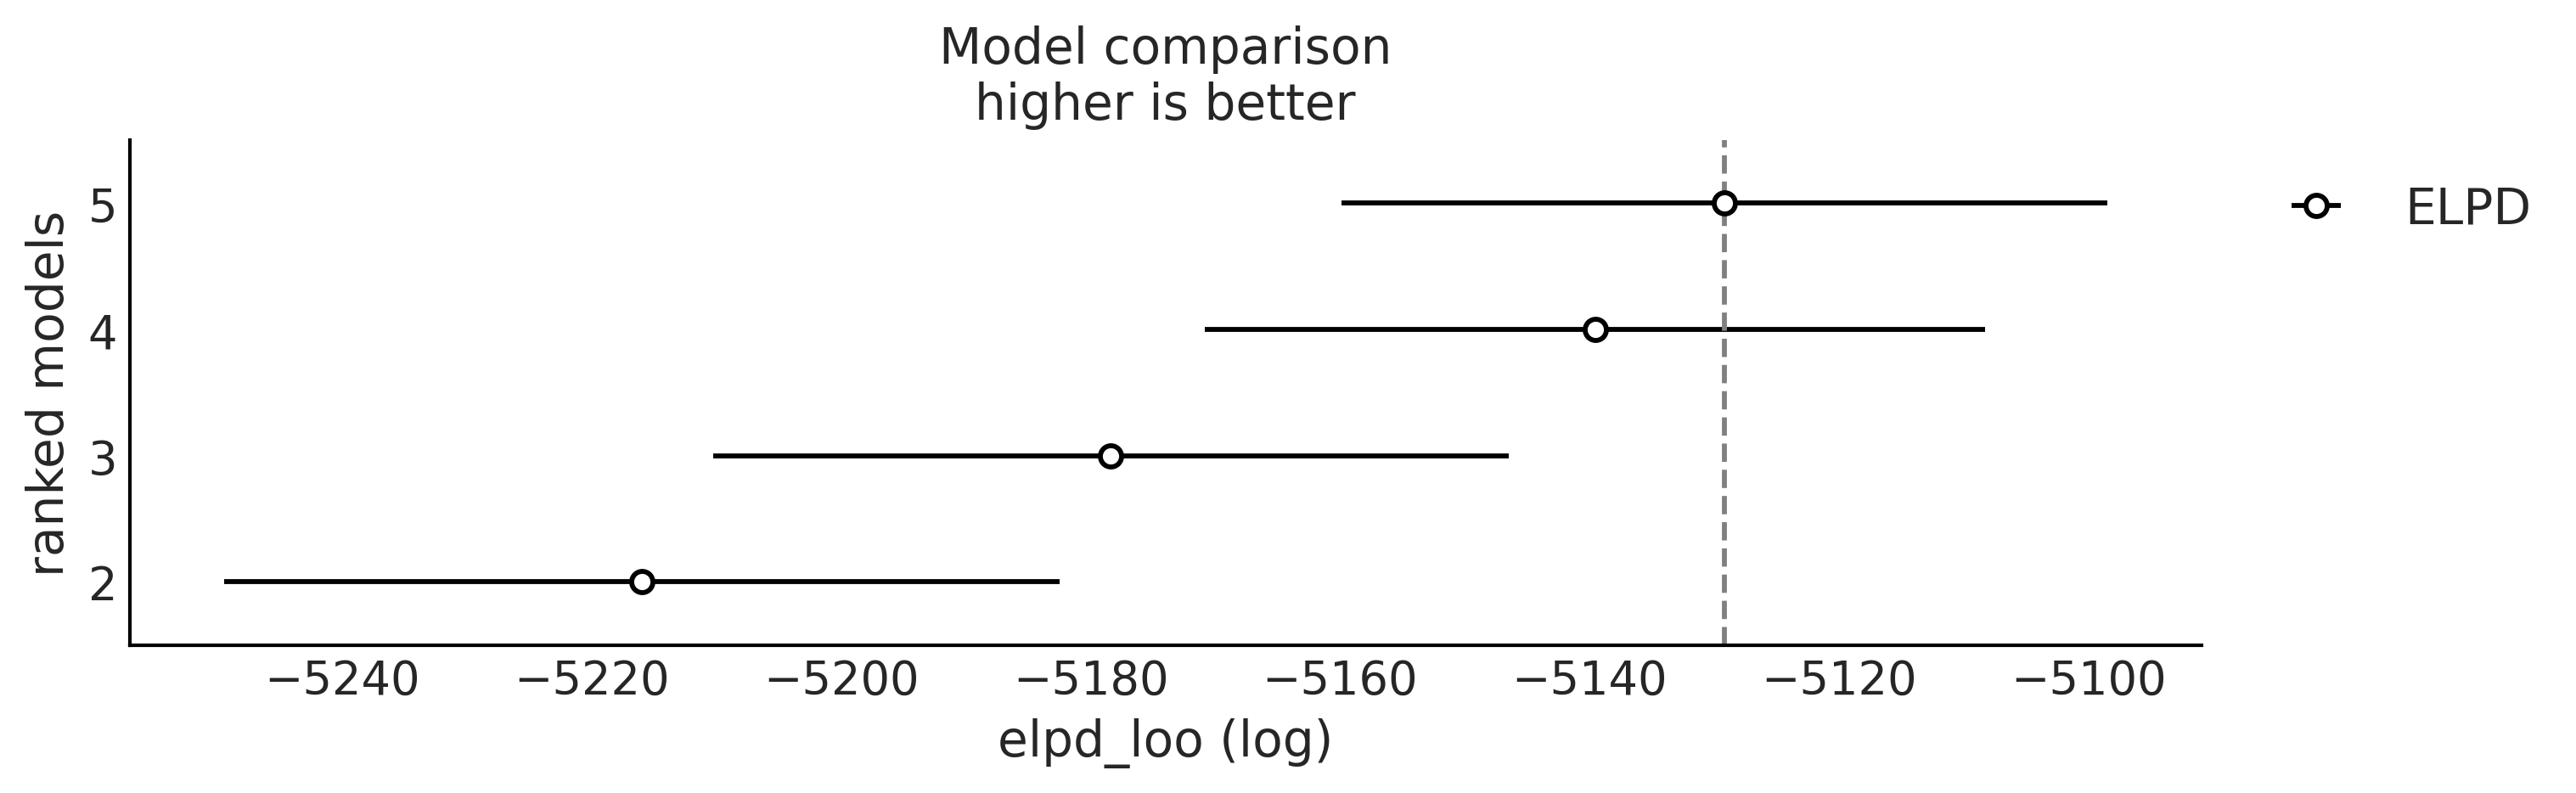

In [14]:
az.plot_compare(comp, figsize=(10, 3), plot_ic_diff=False)
plt.savefig('../fig/mixture_models_loo.png')

## Zero-Inflated Regression

In [15]:
fish_data = pd.read_csv('data/fish.csv')

In [16]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 1)
    β = pm.Normal('β', 0, 1, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    idata_ZIP_reg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ψ, α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


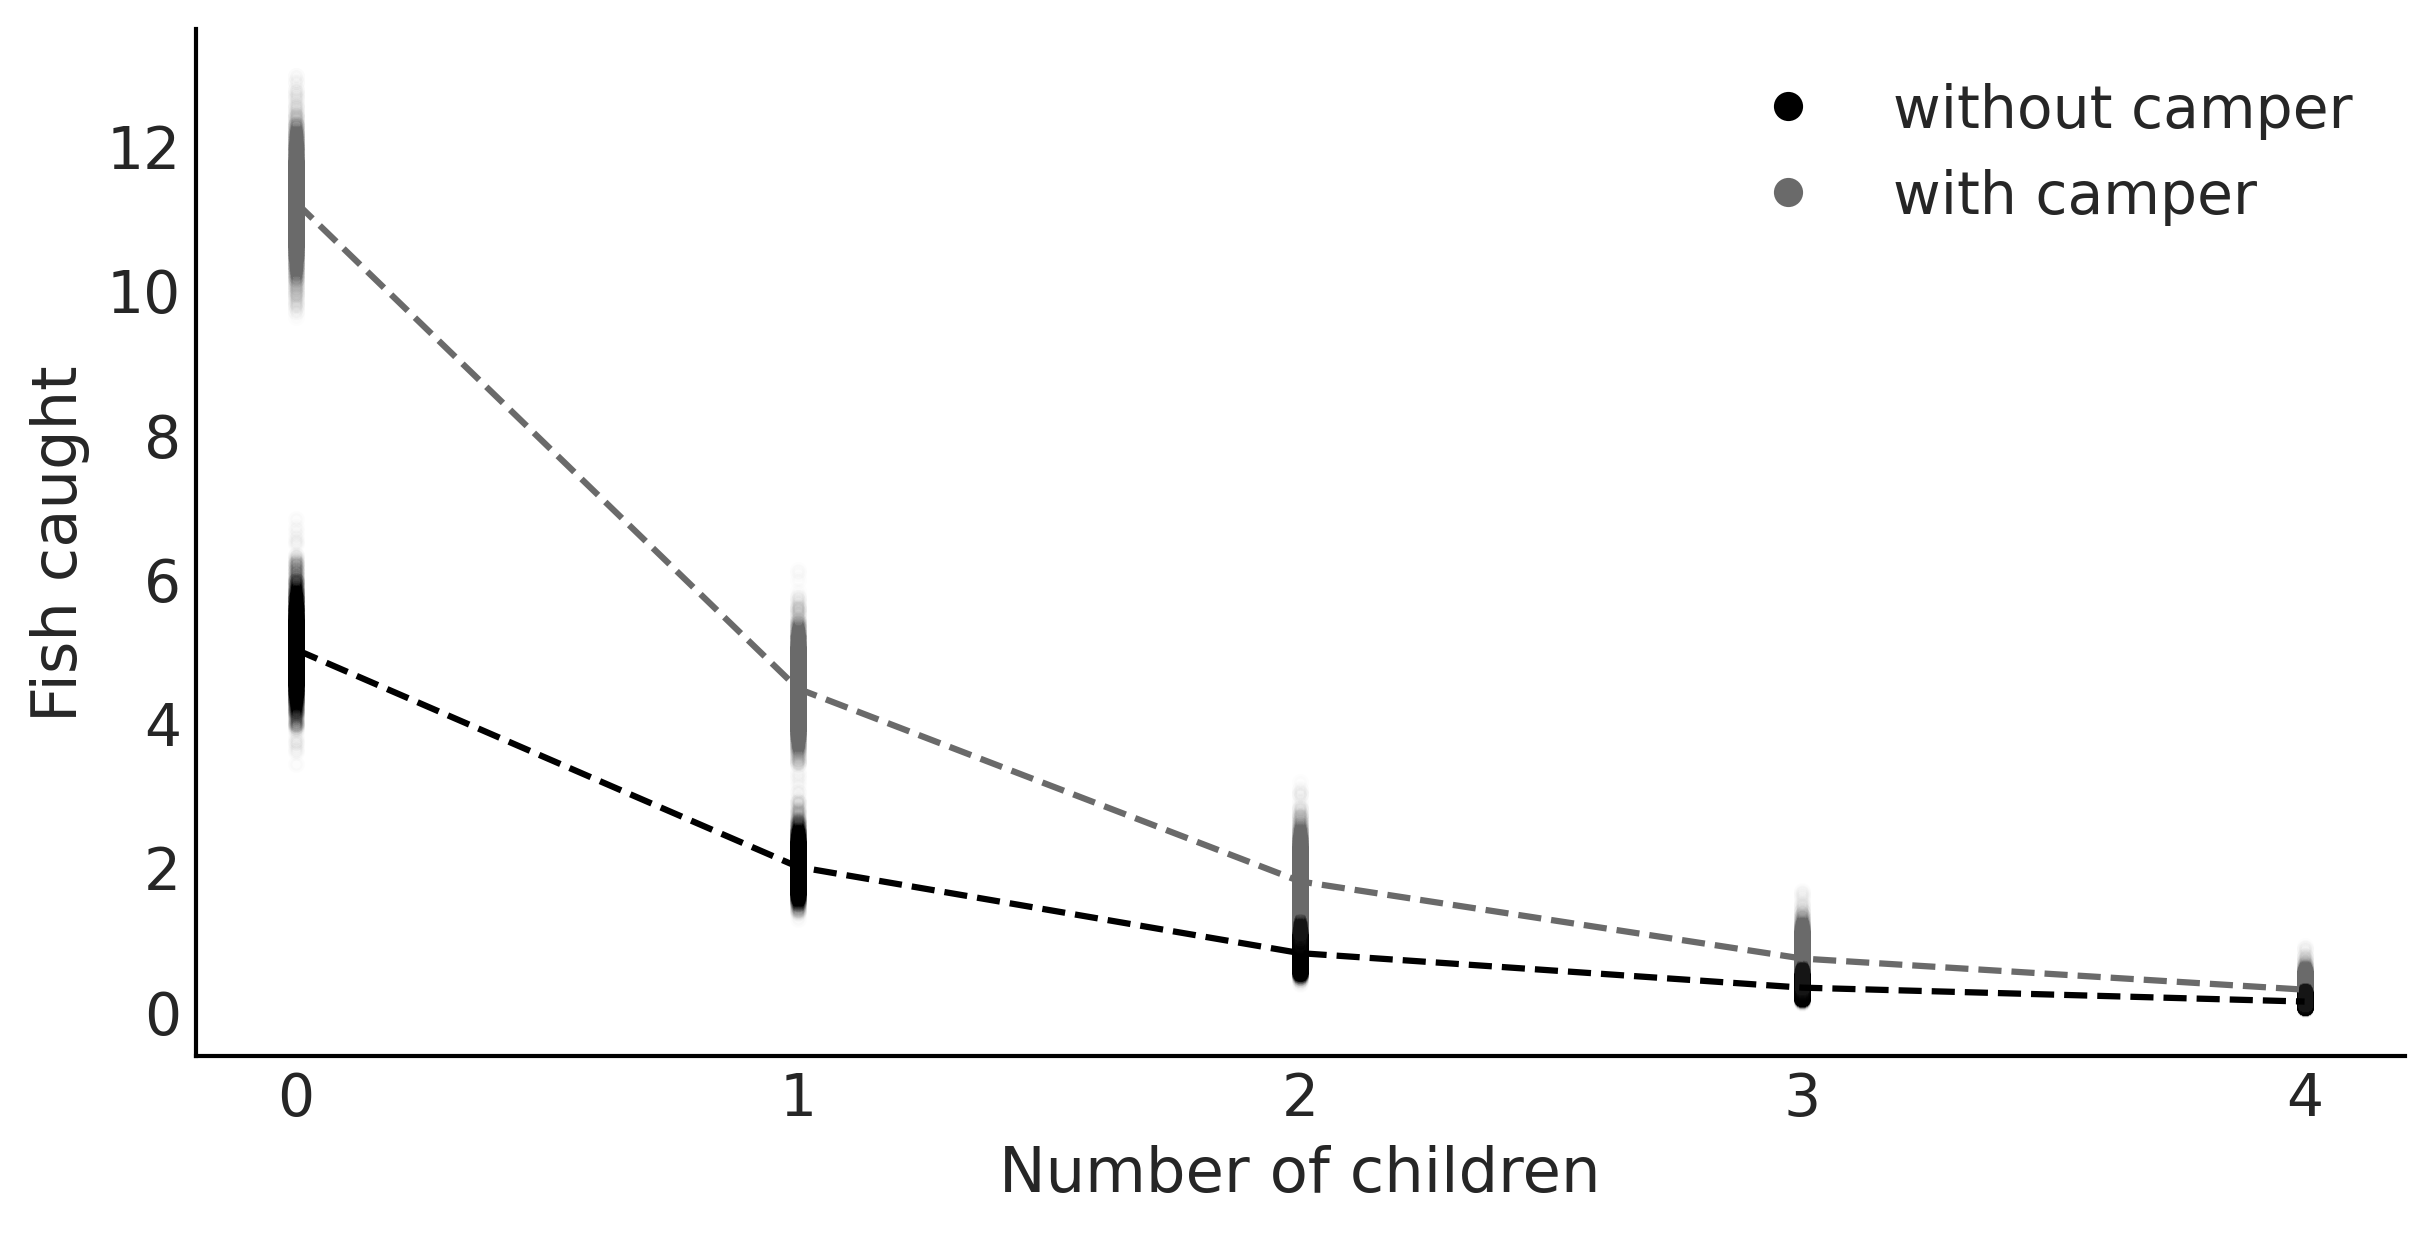

In [17]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []

posterior = az.extract(idata_ZIP_reg)

without_camper = posterior['α'] + posterior['β'][0] * xr.DataArray(children)
with_camper = without_camper + posterior['β'][1]
fish_count_pred_0 = np.exp(without_camper)
fish_count_pred_1 = np.exp(with_camper)

_, ax = plt.subplots(figsize=(8, 4))
ax.plot(children, fish_count_pred_0.T, 'C0.', alpha=0.01)
ax.plot(children, fish_count_pred_1.T, 'C1.', alpha=0.01)
ax.plot(children, fish_count_pred_0.mean("sample"), 'C0', ls="--")
ax.plot(children, fish_count_pred_1.mean("sample"), 'C1', ls="--")
ax.set_xticks(children)
ax.set_xlabel('Number of children')
ax.set_ylabel('Fish caught')
ax.plot([], 'C0o', label='without camper')
ax.plot([], 'C1o', label='with camper')
plt.legend()
plt.savefig('../fig/ZIP_reg.png')

In [18]:
crab = pd.read_csv("data/horseshoe_crab.csv")

In [19]:
model_crab_p = bmb.Model("satellite ~ width + C(color)", family="poisson", data=crab)
idata_crab_p = model_crab_p.fit(idata_kwargs={"log_likelihood":True}, random_seed=123)
model_crab_p.predict(idata_crab_p, kind="pps")

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, width, C(color)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [20]:
model_crab_hp = bmb.Model("satellite ~ width + C(color)", family="hurdle_poisson", data=crab)
idata_crab_hp = model_crab_hp.fit(idata_kwargs={"log_likelihood":True}, random_seed=123)
model_crab_hp.predict(idata_crab_hp, kind="pps")

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [satellite_psi, Intercept, width, C(color)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [21]:
model_crab_nb = bmb.Model("satellite ~ width + C(color)", family="negativebinomial", data=crab)
idata_crab_nb = model_crab_nb.fit(idata_kwargs={"log_likelihood":True}, random_seed=123)
model_crab_nb.predict(idata_crab_nb, kind="pps")

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [satellite_alpha, Intercept, width, C(color)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [22]:
model_crab_hnb = bmb.Model("satellite ~ width + C(color)", family="hurdle_negativebinomial", data=crab)
idata_crab_hnb = model_crab_hnb.fit(idata_kwargs={"log_likelihood":True}, random_seed=123)
model_crab_hnb.predict(idata_crab_hnb, kind="pps")

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


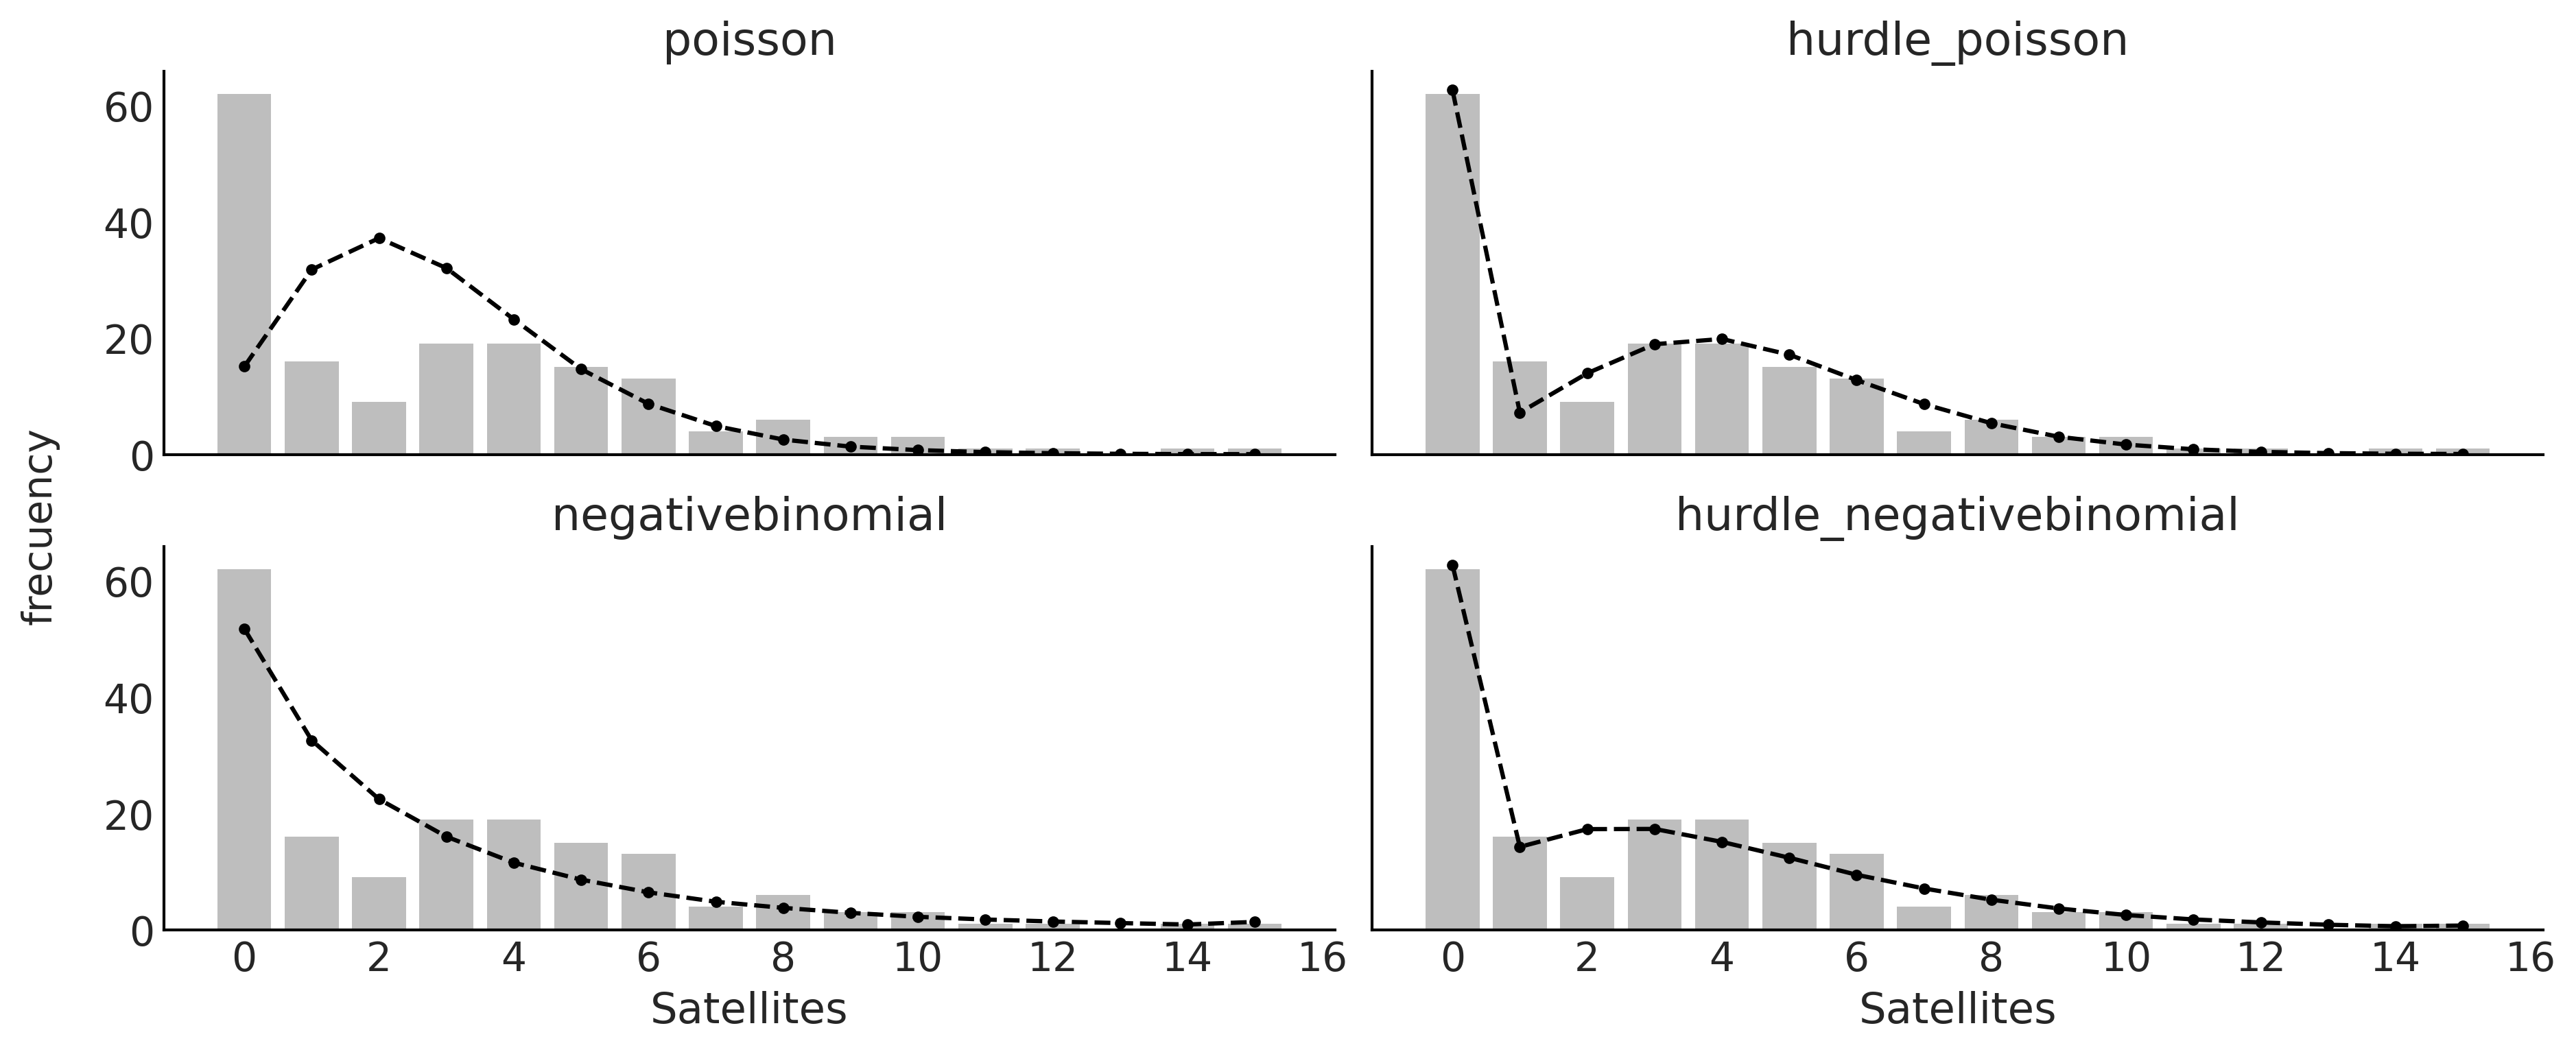

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5), sharex=True, sharey=True)

for ax, idata, model in zip(axes.ravel(), 
                            [idata_crab_p, idata_crab_hp, idata_crab_nb, idata_crab_hnb],
                            [model_crab_p, model_crab_hp, model_crab_nb, model_crab_hnb]):
    
    dims = idata.posterior_predictive.dims
    n_samples = dims["chain"] * dims["draw"]

    ax.hist(crab.satellite.values, bins=np.array(range(0, 17)), color="C2", align="left", rwidth=0.8)
    xs = np.histogram(idata.posterior_predictive["satellite"].values.ravel(), bins=np.array(range(0, 17)))[0] / n_samples
    ax.plot(np.arange(16), xs, ".--")
    ax.set_title(model.family.name)

axes[1,1].set_xlabel("Satellites")
axes[1,0].set_xlabel("Satellites")
fig.text(-0.03, 0.5, "frecuency", va="center", rotation="vertical", fontsize=14)

plt.savefig("../fig/crabs_fits.png")

In [24]:
cmp = az.compare({"P": idata_crab_p, "HP": idata_crab_hp, "NB": idata_crab_nb, "HNB": idata_crab_hnb})
cmp

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
HNB,0,-372.703129,6.236613,0.000000,0.000000,13.686522,0.000000,False,log
NB,1,-380.323229,5.638368,7.620100,0.417993,14.119153,5.727559,False,log
HP,2,-382.544325,8.827455,9.841196,0.582007,17.738482,6.587130,False,log
P,3,-468.702468,16.591757,95.999339,0.000000,24.876144,19.529589,False,log


/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


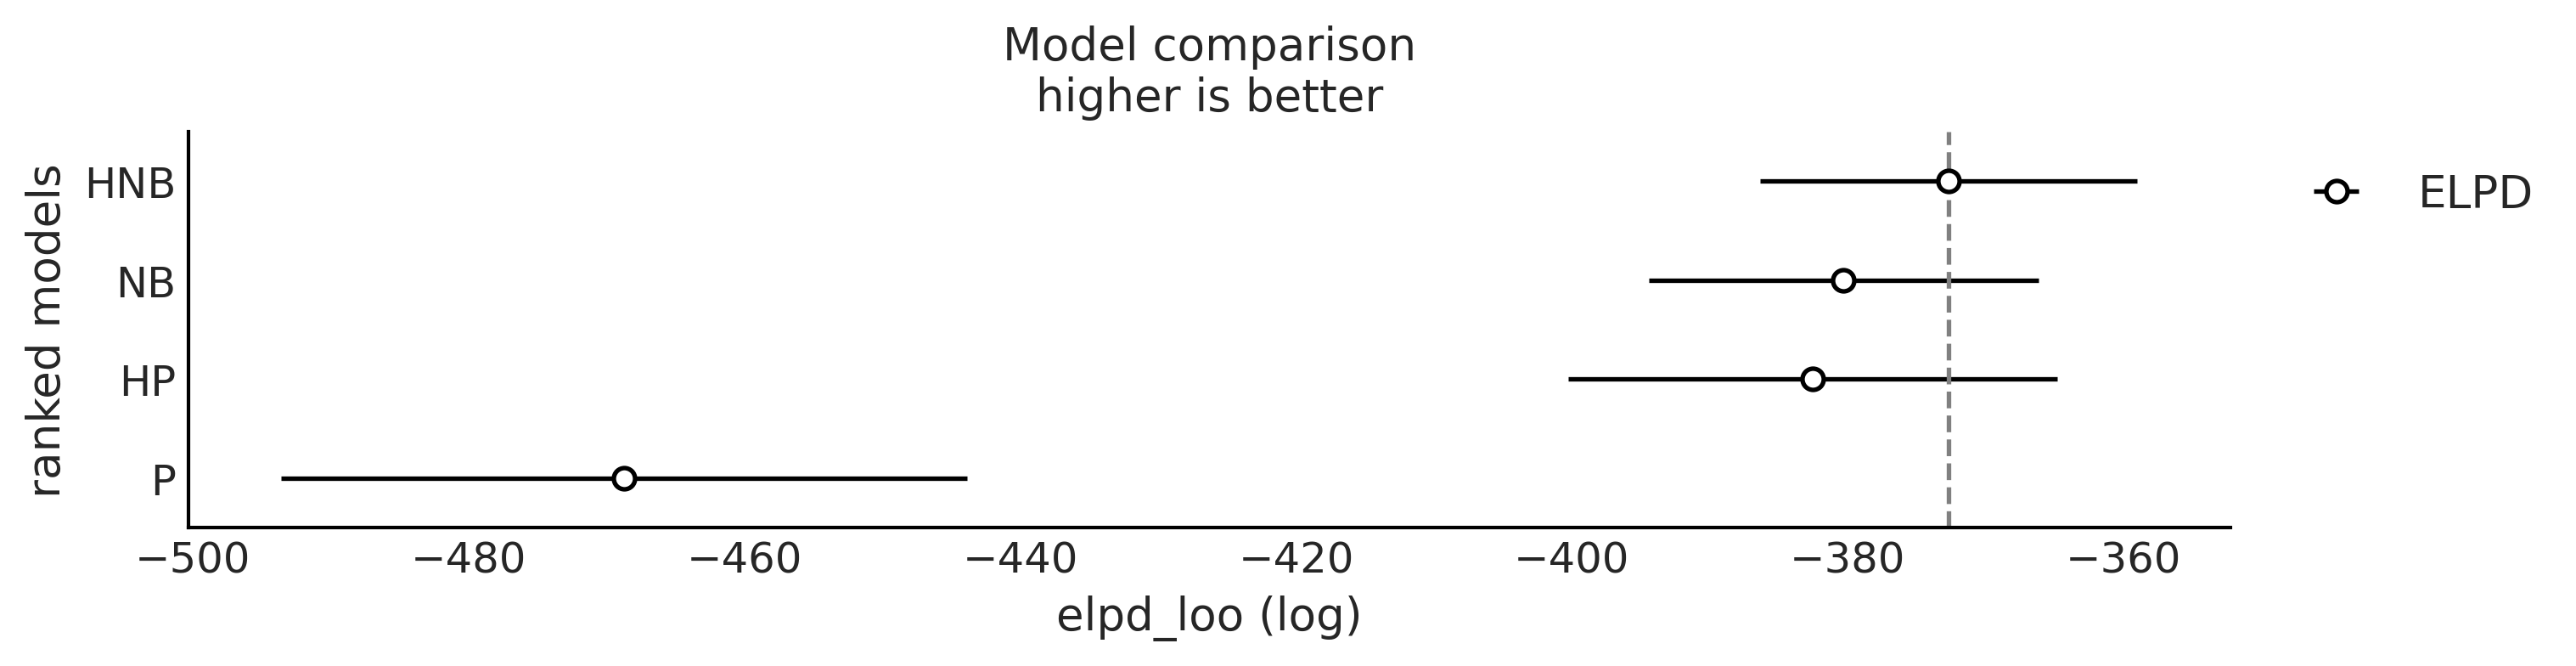

In [25]:
az.plot_compare(cmp, figsize=(10, 2.5), plot_ic_diff=False)
plt.savefig("../fig/crabs_compare.png")

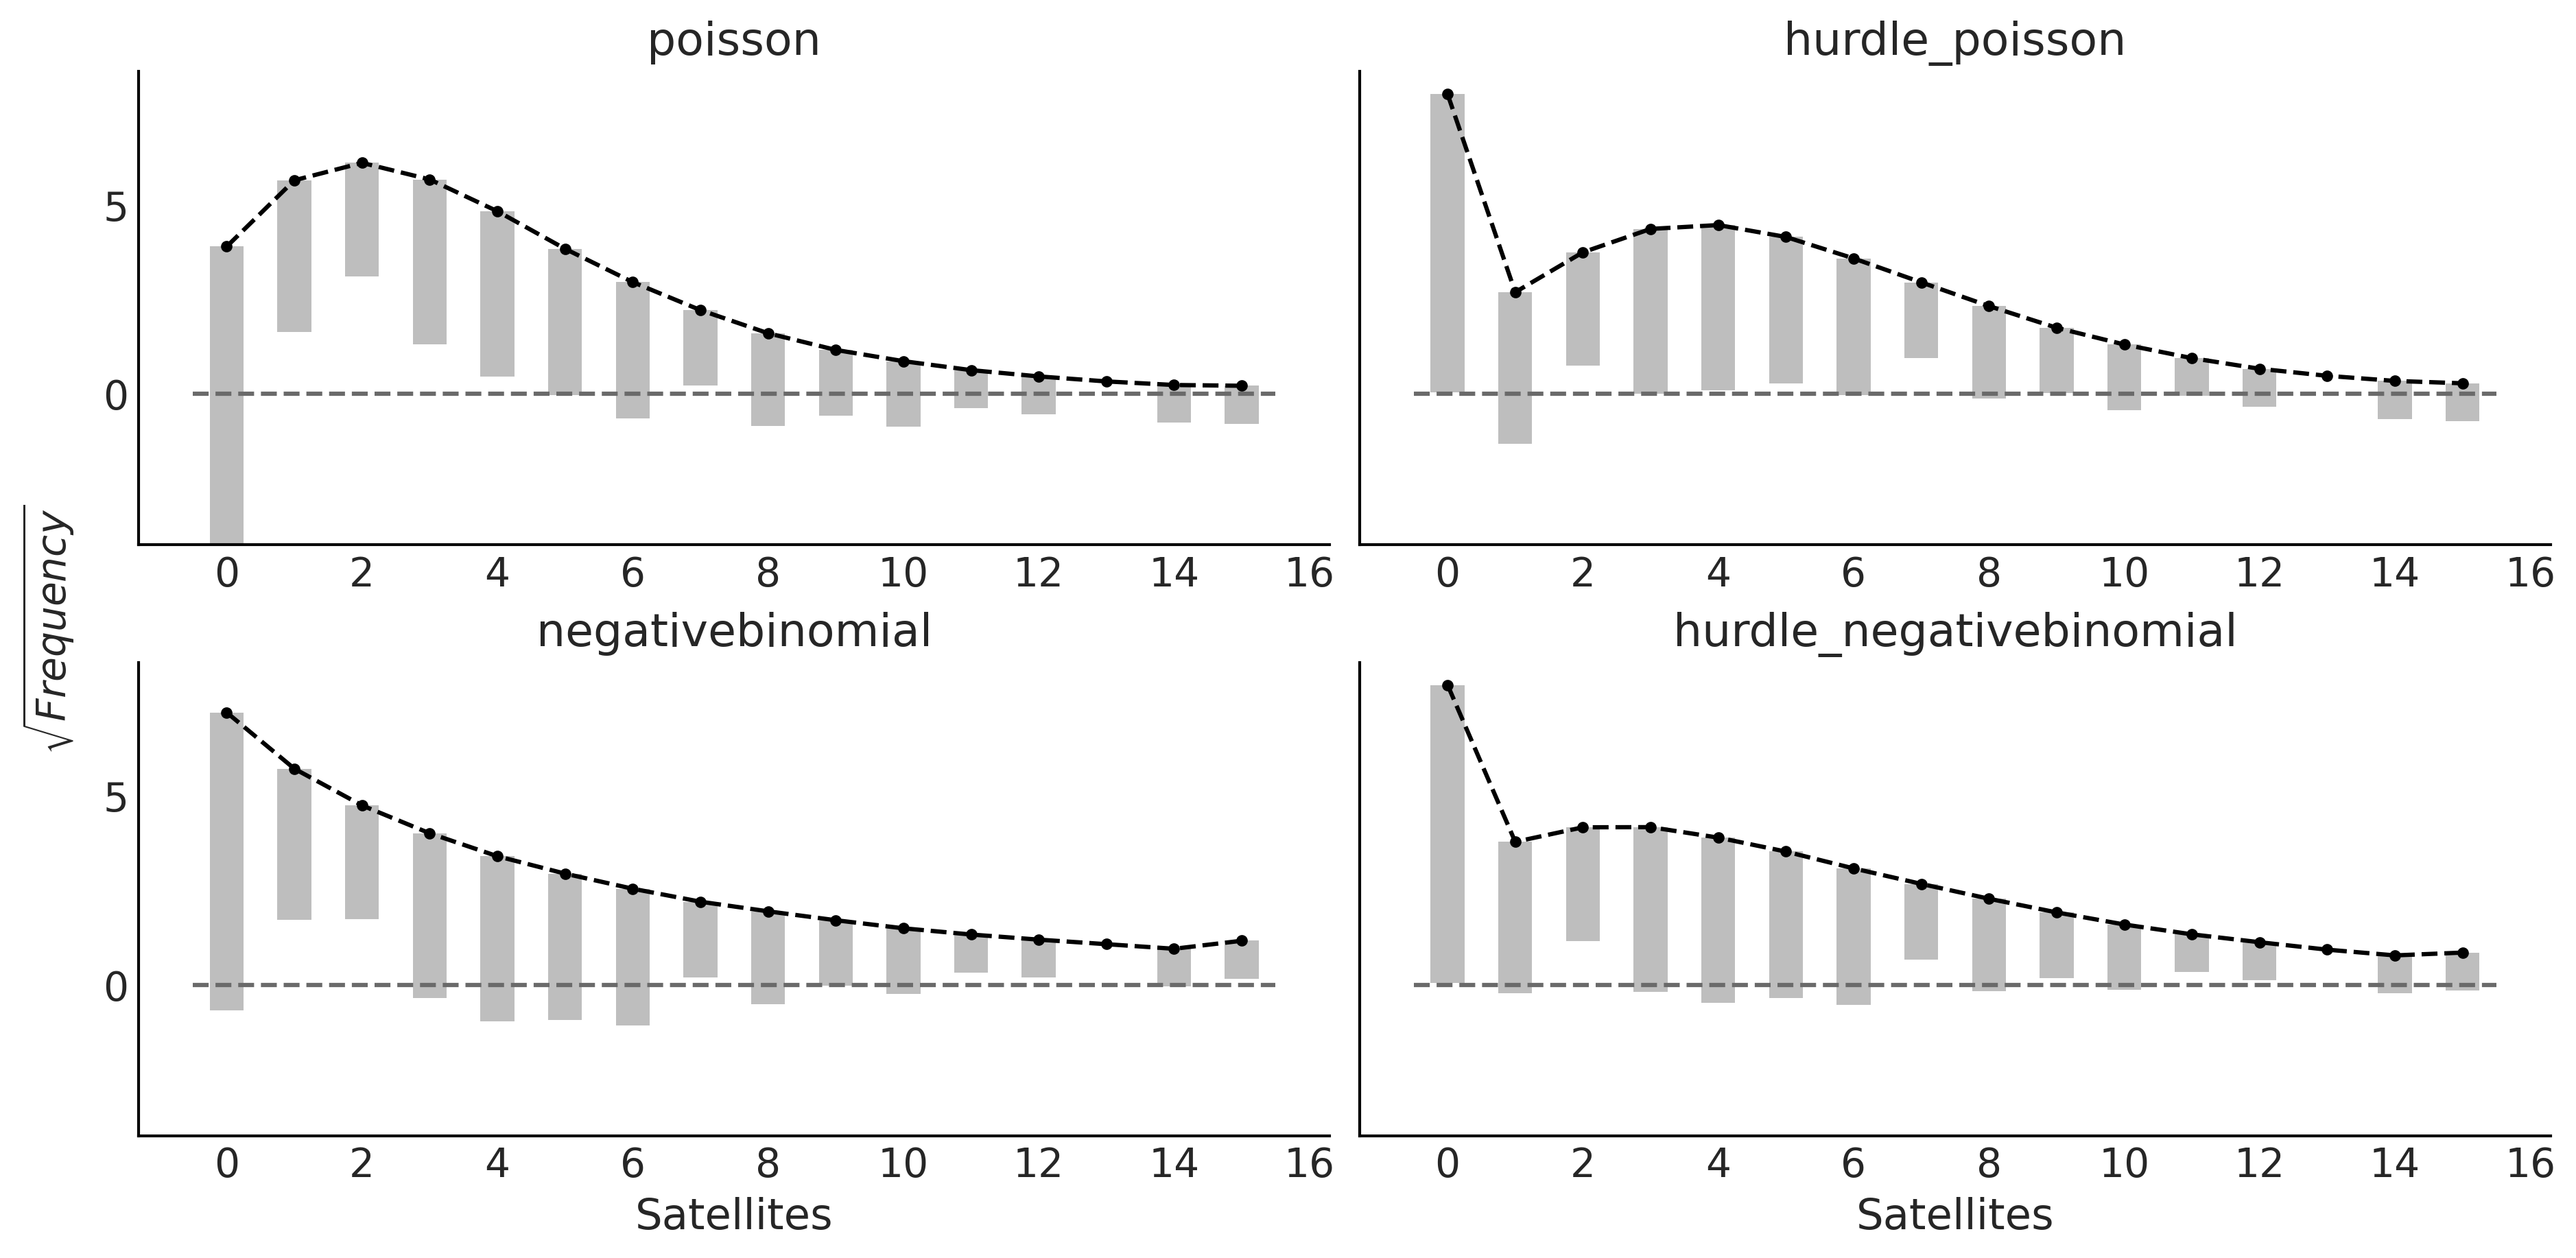

In [26]:
def rotogram(idata, ax):
    max_ = 17
    bins = np.array(range(0, max_))
    dims = idata.posterior_predictive.dims
    n_samples = dims["chain"] * dims["draw"]
    pred =  (np.histogram(idata.posterior_predictive["satellite"].values.ravel(),  bins=bins)[0] / n_samples)**0.5
    observed = np.histogram(crab["satellite"].values, bins=bins)[0]**0.5

    ax.bar(bins[:-1], observed, 0.5, bottom=pred-observed, color="C2")
    ax.plot(bins[:-1], pred,  "k.--")
    ax.hlines(0, -0.5, max_-1.5, linestyle="--", color="C1")


fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12, 6))
for ax, idata, model in zip(axes.ravel(), 
                            [idata_crab_p, idata_crab_hp, idata_crab_nb, idata_crab_hnb],
                            [model_crab_p, model_crab_hp, model_crab_nb, model_crab_hnb]):
    rotogram(idata, ax)
    ax.set_title(model.family.name)

axes[1,1].set_xlabel("Satellites")
axes[1,0].set_xlabel("Satellites")
fig.text(-0.03, 0.5, "$\sqrt{Frequency}$", va="center", rotation="vertical", fontsize=14)
plt.savefig("../fig/crabs_rootograms.png")

## Non-finite mixture models

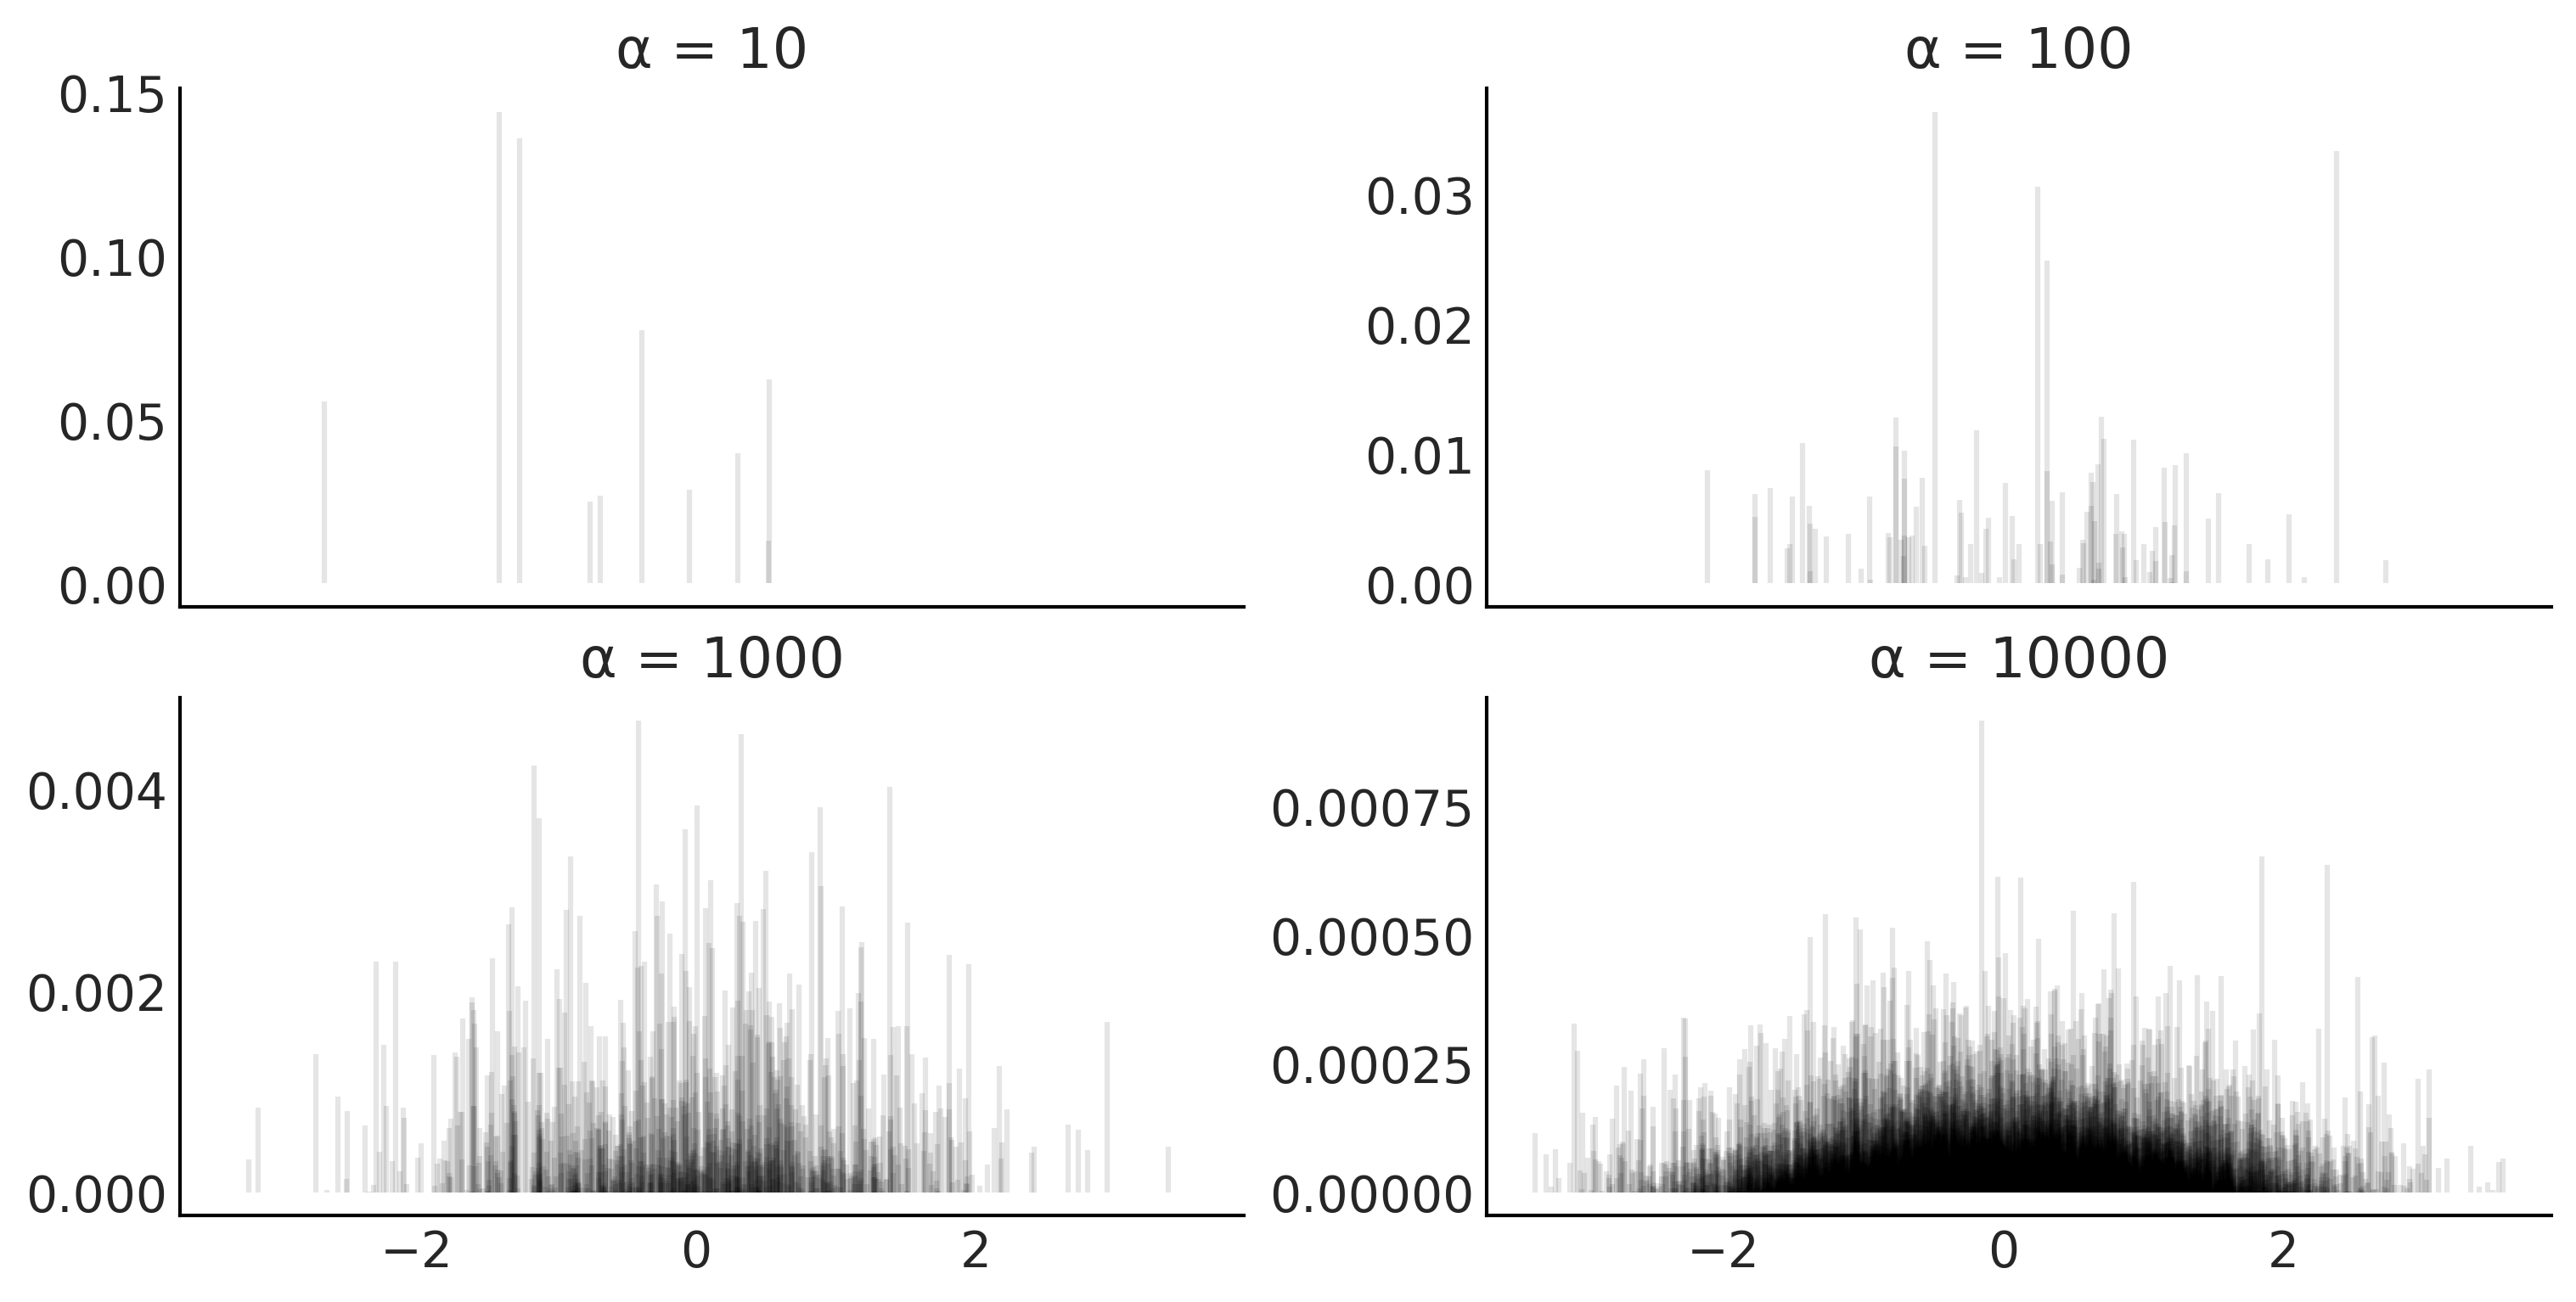

In [27]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    
    Parameters
    ----------
    α : float
        concentration parameter
    H : Preliz distribution
        Base distribution
    K : int
        number of components
    
    Returns
    -------
    locs : array
        locations
    w : array
        probabilities
    """
    βs = pz.Beta(1, α).rvs(K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    locs = H.rvs(size=K)
    return locs, w

# Parameters DP
H = pz.Normal(0, 1)
alphas = [10, 100, 1000, 10000]
Ks = alphas * 10

# plot
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, (α, K) in enumerate(zip(alphas, Ks)):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0', alpha=0.1)
    ax[idx].set_title('α = {}'.format(α))

plt.savefig('../fig/stick_breaking.png')

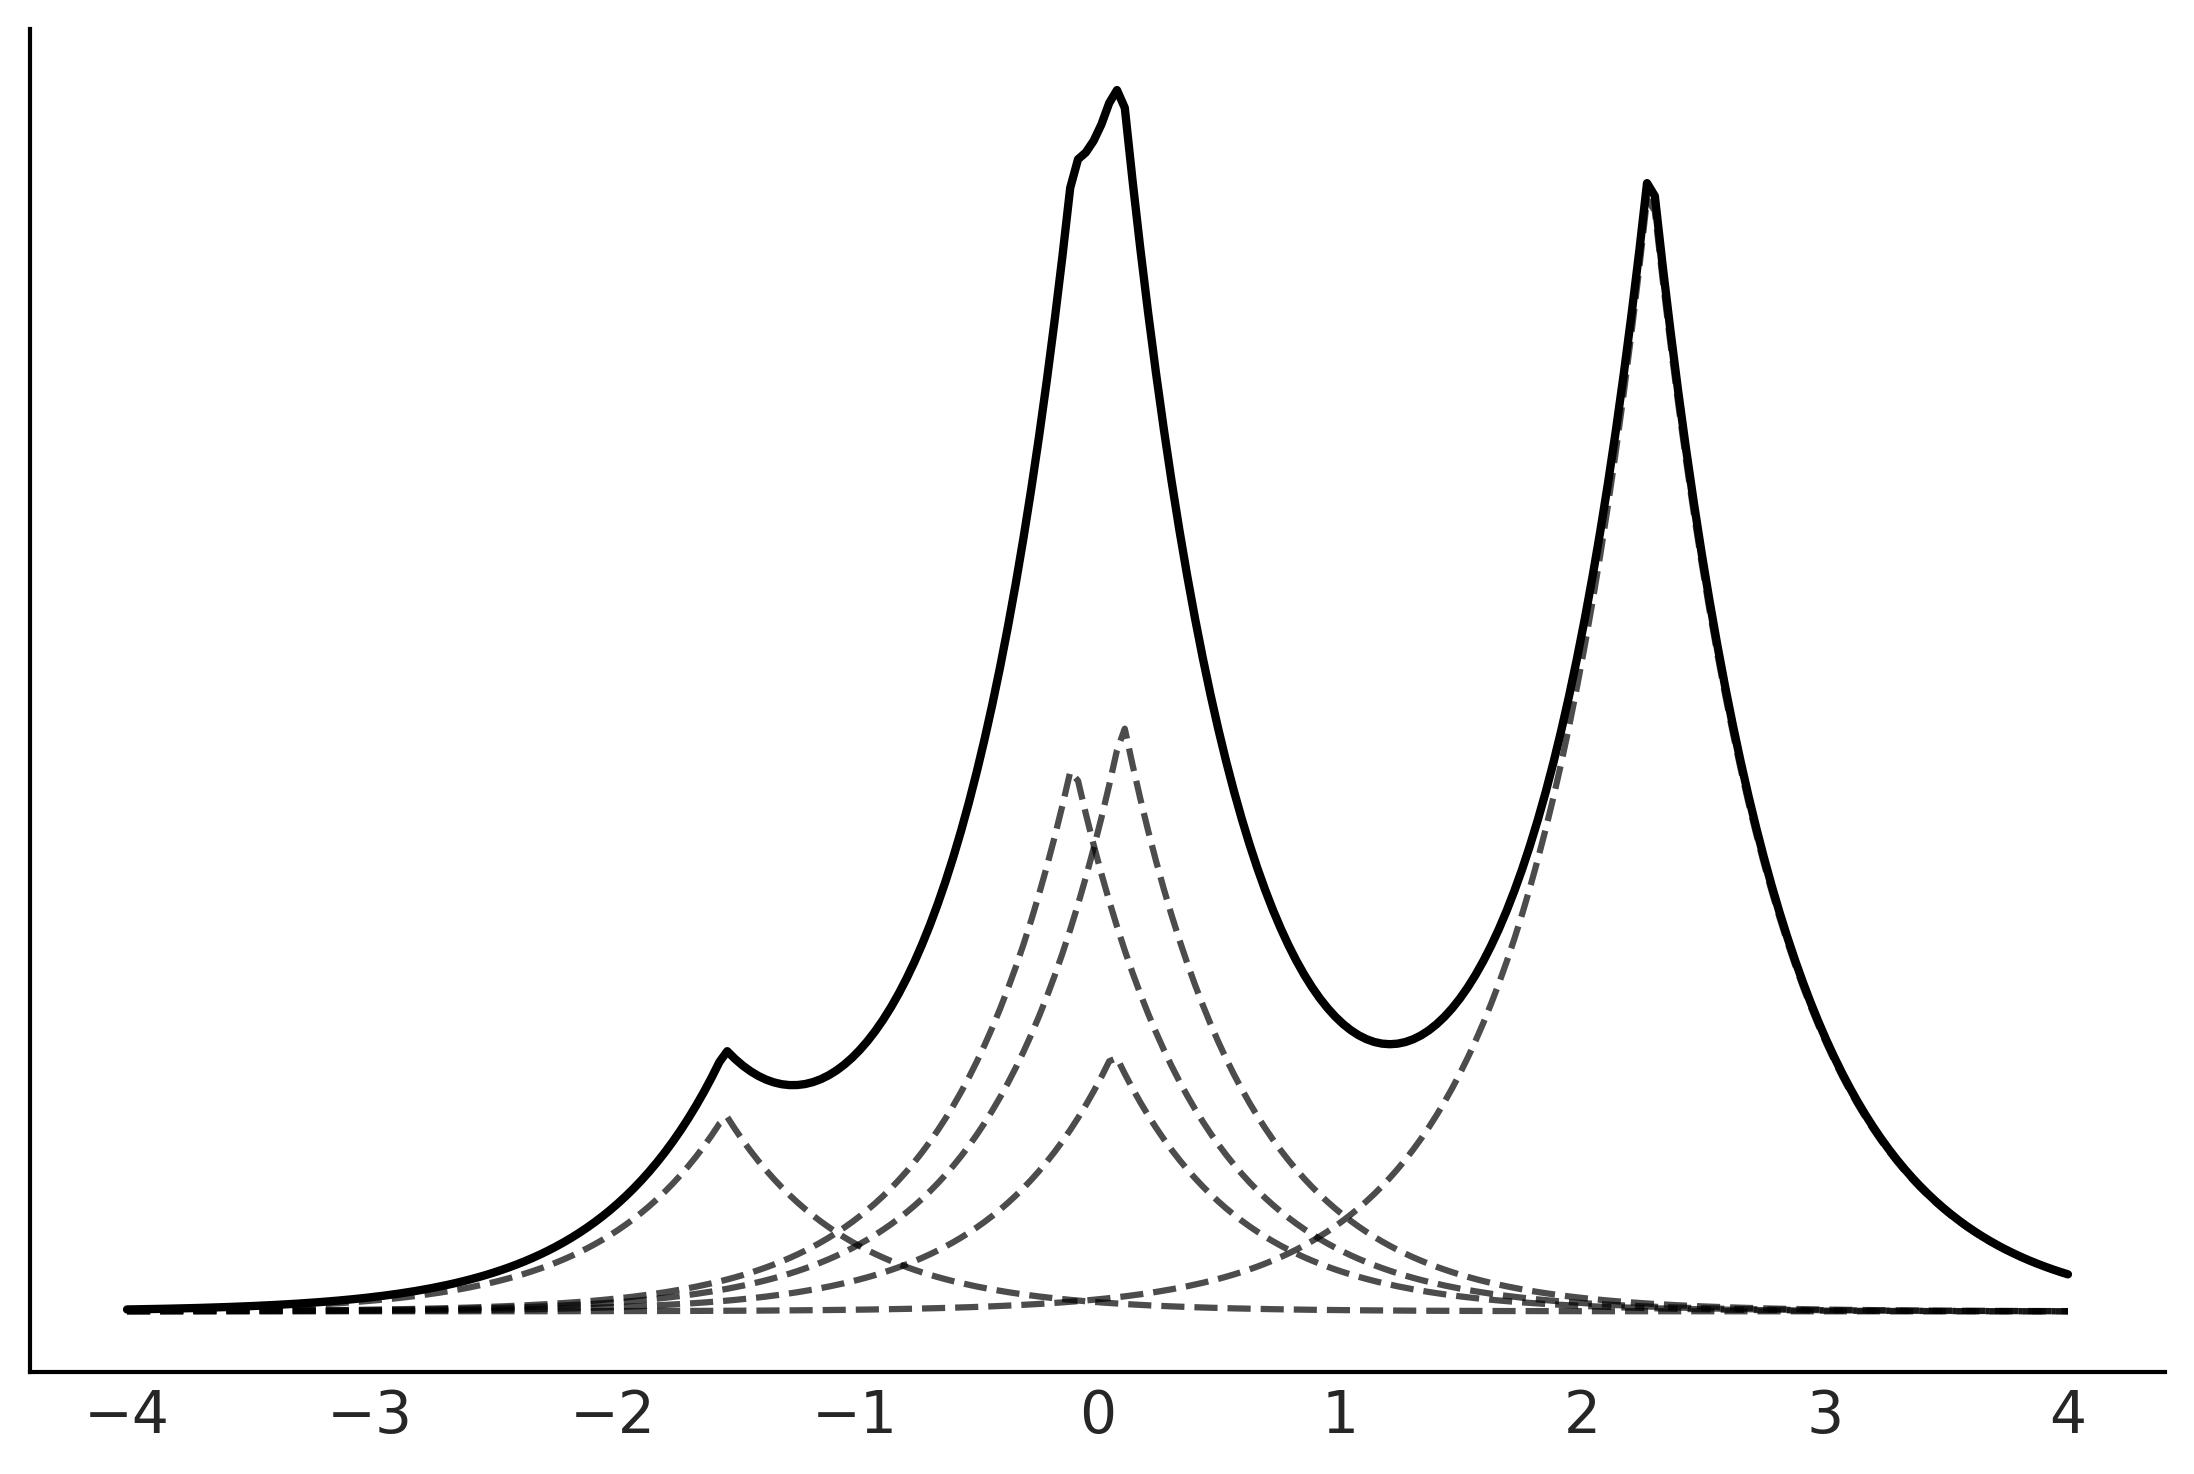

In [28]:
α = 10
H = pz.Normal(0, 1)
K = 5

x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)

dist = pz.Laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])

plt.savefig('../fig/Laplace_DP_mixture.png')

In [29]:
K = 10

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pt.concatenate([[1.], pt.extra_ops.cumprod(1. - β)[:-1]]) + 1E-6
    return w/w.sum()

In [30]:
with pm.Model() as model_DP:
    α = pm.Gamma('α', 2, 1)
    w = pm.Deterministic('w', stick_breaking(α, K)) 
    means = pm.Normal('means',
                      mu=np.linspace(cs_exp.min(), cs_exp.max(), K),
                      sigma=5, shape=K,
                      transform=pm.distributions.transforms.univariate_ordered,
                     )
    
    sd = pm.HalfNormal('sd', sigma=5, shape=K)
    obs = pm.NormalMixture('obs', w, means, sigma=sd, observed=cs_exp.values)
    idata = pm.sample(random_seed=123, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 209 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [31]:
az.summary(idata, var_names=['α'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.96,0.409,0.326,1.704,0.009,0.007,1672.0,1740.0,1.0


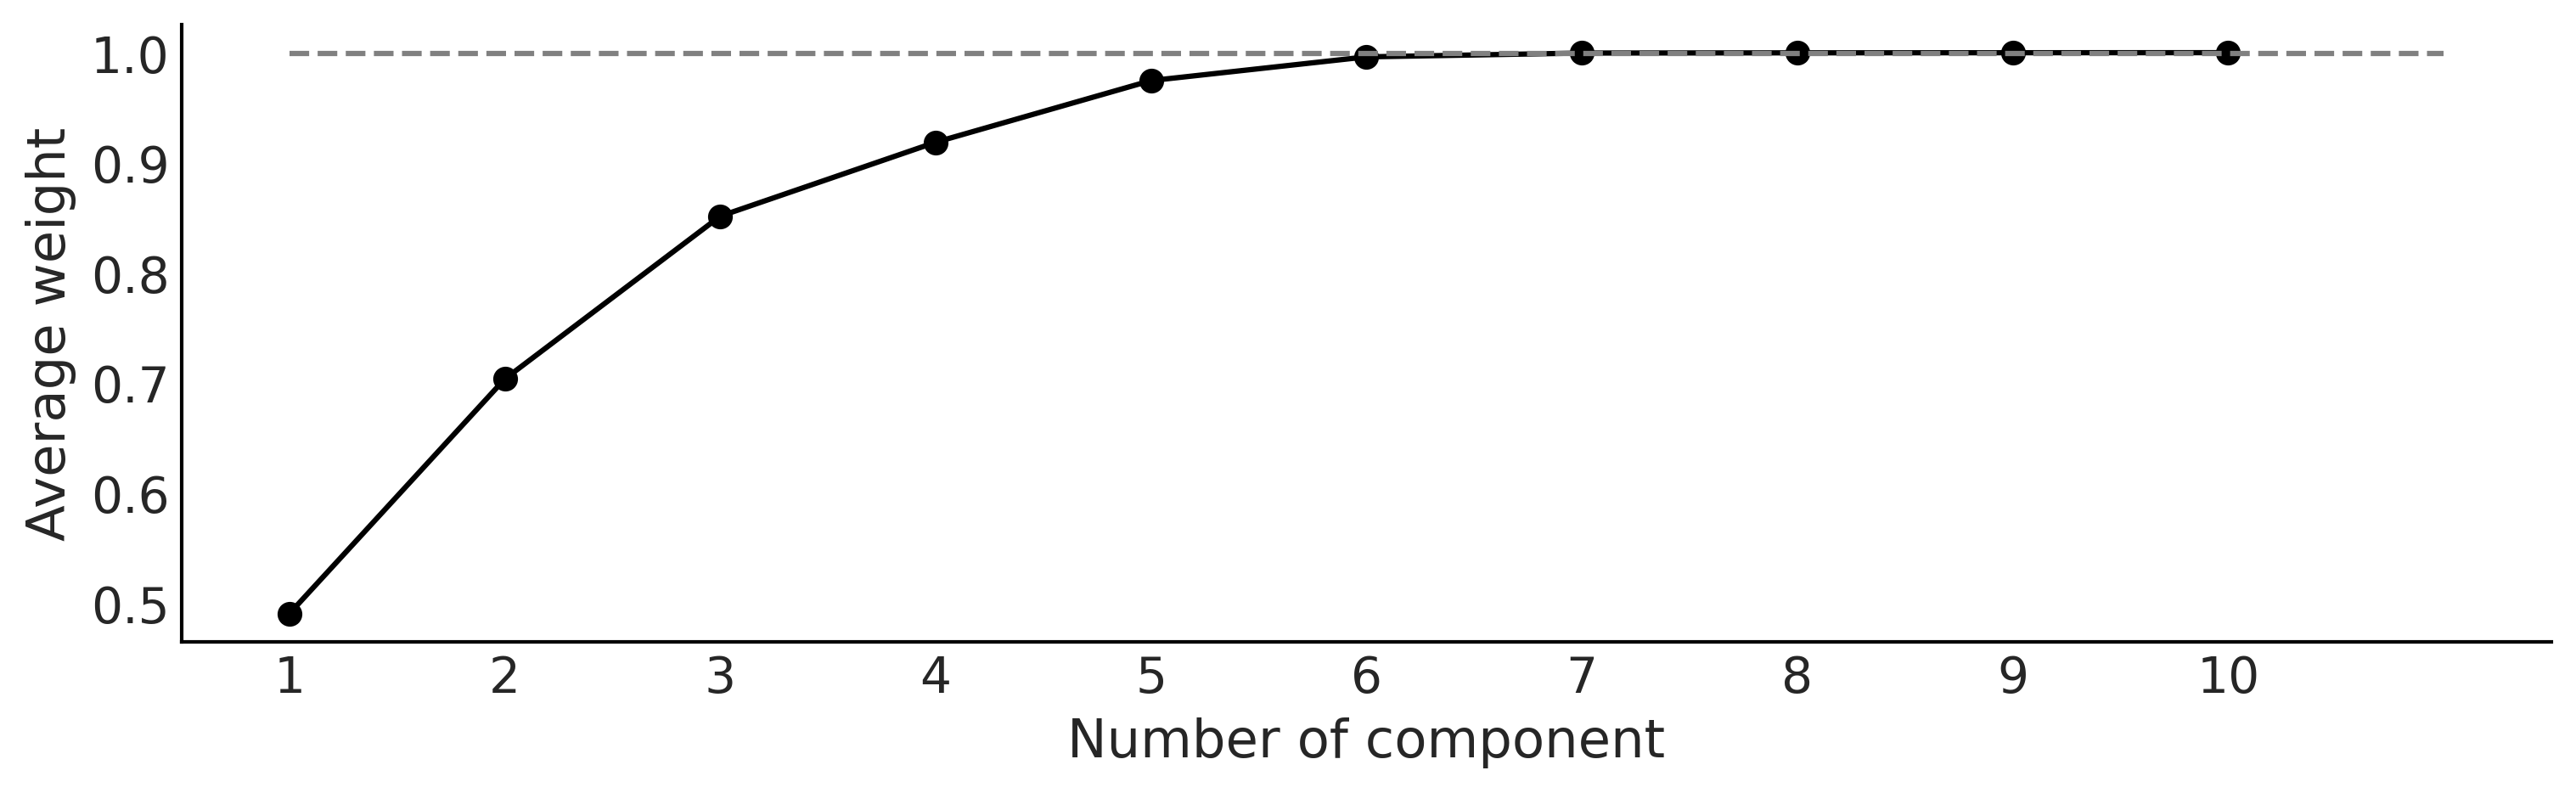

In [32]:
plt.figure(figsize=(10, 3))
plot_w = np.arange(K)
plt.plot(np.cumsum(np.sort(idata.posterior['w'].mean(("chain", "draw")))[::-1]), 'o-')
plt.hlines(0.999, 0, K, ls="--", color="0.5")
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Number of component')
plt.ylabel('Average weight')
plt.savefig('../fig/components_DP_mixture.png')

In [33]:
x_plot = np.linspace(cs.exp.min()-1, cs.exp.max()+1, 200)

posterior = idata.posterior.stack(samples=("chain", "draw"))

post_pdf_contribs = pz.Normal(posterior['means'].values[:, np.newaxis, :],
                              posterior['sd'].values[:, np.newaxis, :]).pdf(np.atleast_3d(x_plot))
post_pdfs = (posterior['w'].values[:, np.newaxis, :] * post_pdf_contribs).sum(axis=0)

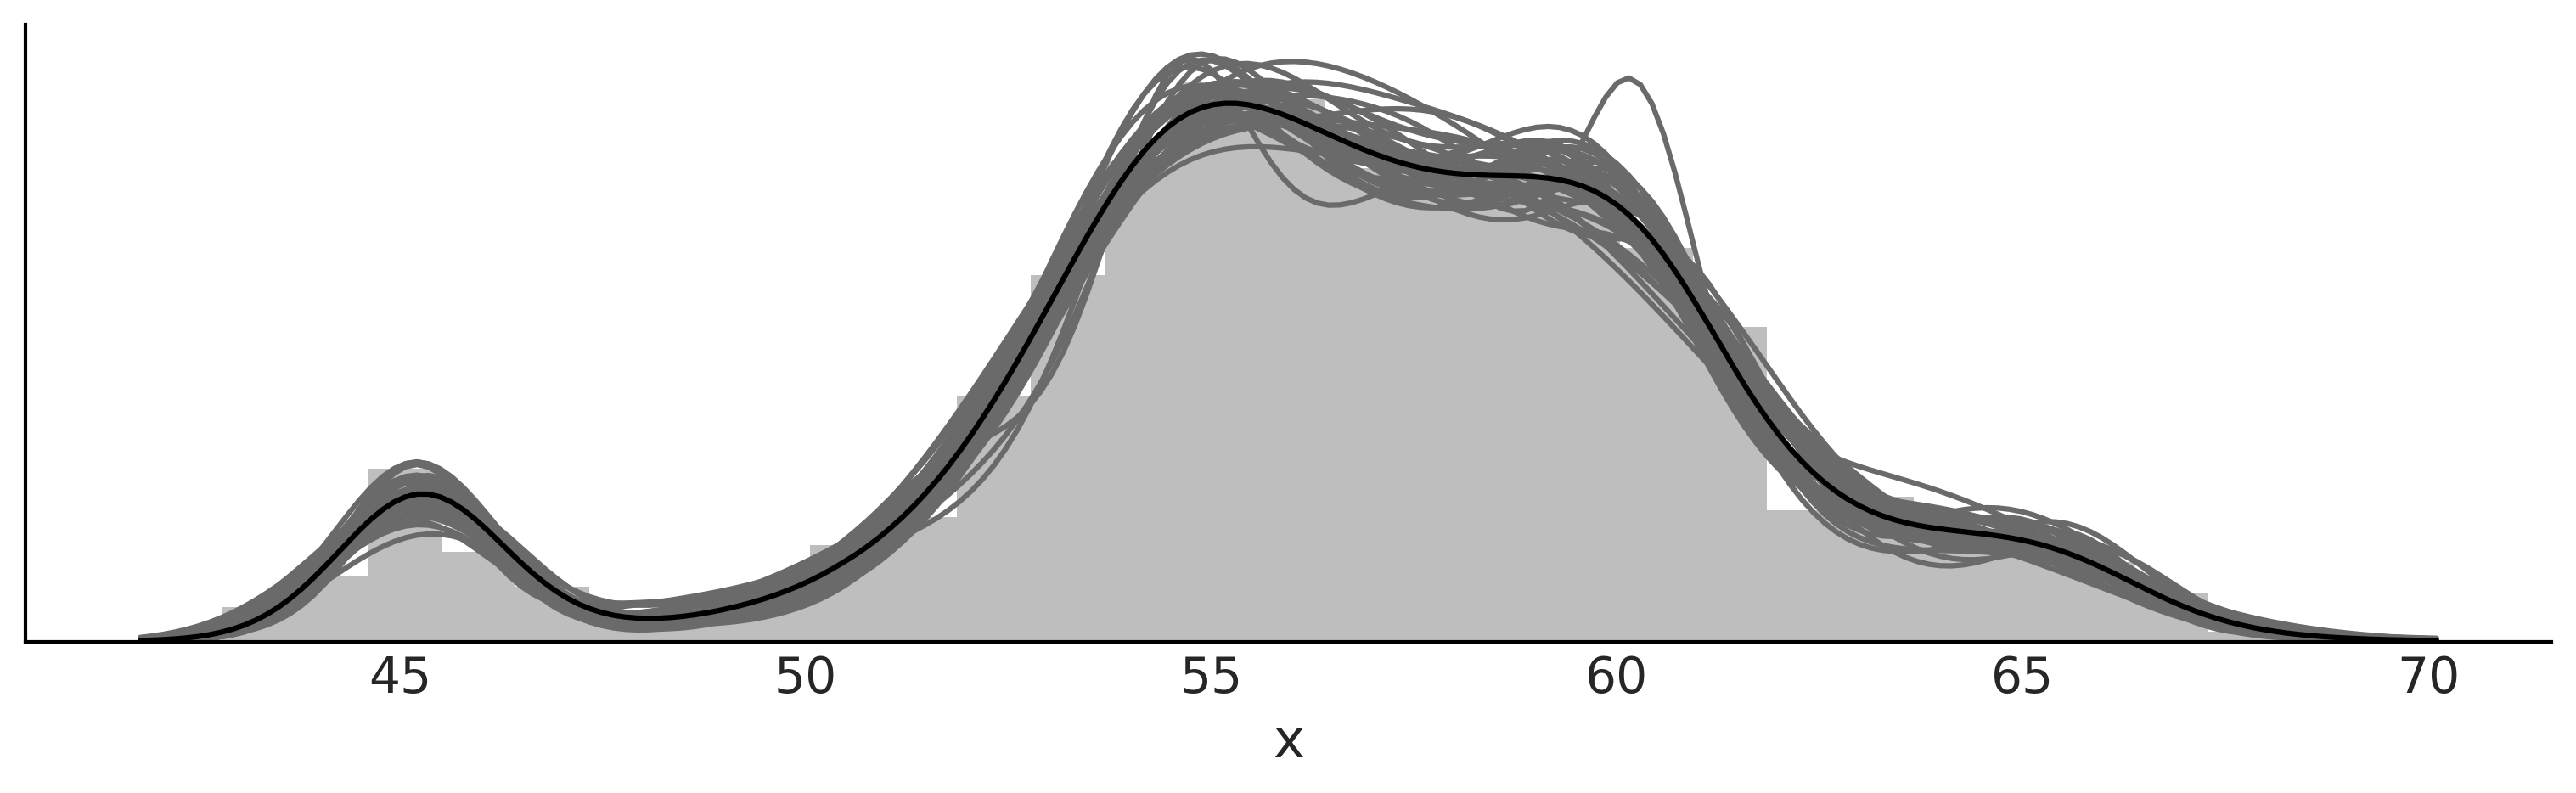

In [34]:
plt.figure(figsize=(10, 3))

plt.hist(cs_exp.values, bins="auto", density=True, color="C2")
plt.plot(x_plot, post_pdfs[:,::100], c='C1')
plt.plot(x_plot, post_pdfs.mean(axis=1), c='k')

plt.xlabel('x')
plt.yticks([])
plt.savefig('../fig/DP_mixture.png')